https://www.kaggle.com/artgor/exploration-of-data-step-by-step/notebook

In [5]:
import numpy as np
import pandas as pd
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from PIL import Image
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, roc_auc_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix as sk_cmatrix
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import gc
from catboost import CatBoostClassifier
from tqdm import tqdm_notebook
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import random
import warnings
warnings.filterwarnings('ignore')
from functools import partial
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 100)
import scipy as sp
from math import sqrt
from collections import Counter
from nltk.tokenize import TweetTokenizer
import eli5
from IPython.display import display

def kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

In [6]:
breeds = pd.read_csv('./input/breed_labels.csv')
colors = pd.read_csv('./input/color_labels.csv')
states = pd.read_csv('./input/state_labels.csv')

train = pd.read_csv('./input/train/train.csv')
test = pd.read_csv('./input/test/test.csv')
sub = pd.read_csv('./input/test/sample_submission.csv')

train['dataset_type'] = 'train'
test['dataset_type'] = 'test'


In [7]:
all_data = pd.concat([train, test])

In [8]:
print(os.listdir("./input"))

['breed_labels.csv', 'color_labels.csv', 'state_labels.csv', 'test', 'test_images', 'test_metadata', 'test_sentiment', 'train', 'train_images', 'train_metadata', 'train_sentiment']


In [9]:
train.drop('Description', axis=1).head()

Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   
2     1       Brisco    1     307       0       1       2       7       0   
3     1         Miko    4     307       0       2       1       2       0   
4     1       Hunter    1     307       0       1       1       0       0   

   MaturitySize  FurLength  Vaccinated  Dewormed  Sterilized  Health  \
0             1          1           2         2           2       1   
1             2          2           3         3           3       1   
2             2          2           1         1           2       1   
3             2          1           1         1           2       1   
4             2          1           2         2           2       1   

   Quantity  Fee  State                         RescuerID  VideoAmt  \
0         1  100  41326  8480853f516546f6cf33aa88cd76c379         0   
1         1    0  41401  3082c7125d8fb66f7dd4bff4192c8b14         0   
2         1    0  41326  fa90fa5b1ee11c86938398b60abc32cb         0   
3         1  150  41401  9238e4f44c71a75282e62f7136c6b240         0   
4         1    0  41326  95481e953f8aed9ec3d16fc4509537e8         0   

       PetID  PhotoAmt  AdoptionSpeed dataset_type  
0  86e1089a3       1.0              2        train  
1  6296e909a       2.0              0        train  
2  3422e4906       7.0              3        train  
3  5842f1ff5       8.0              2        train  
4  850a43f90       3.0              2        train

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 25 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

Text(0.5, 1.0, 'Adoption speed classes counts')

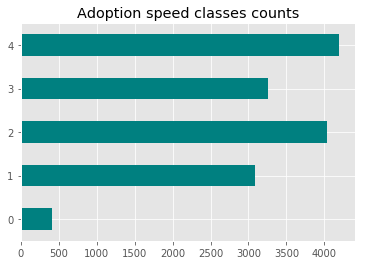

In [11]:
train['AdoptionSpeed'].value_counts().sort_index().plot('barh', color='teal')
plt.title('Adoption speed classes counts')

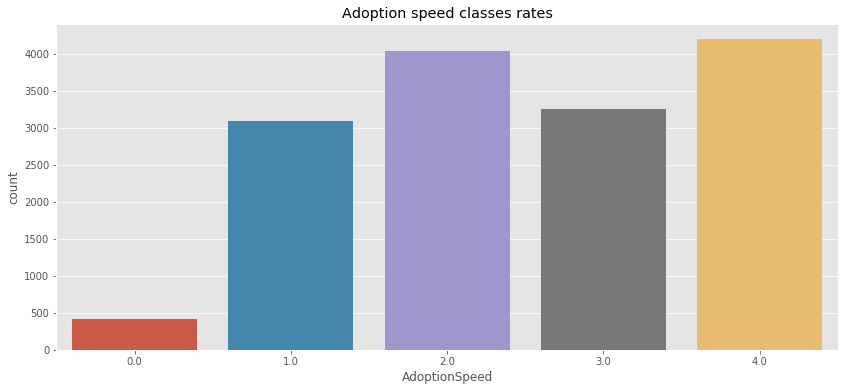

In [12]:
plt.figure(figsize=(14, 6))
g = sns.countplot(
    x='AdoptionSpeed', 
    data=all_data.loc[all_data['dataset_type'] == 'train']
)
plt.title('Adoption speed classes rates')
ax = g.axes

In [13]:
ax

In [14]:
ax.patches

In [15]:
ax.patches[0].get_x()

-0.4

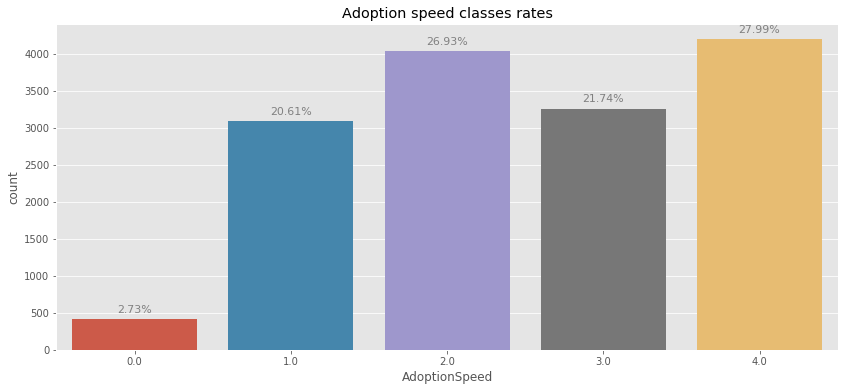

In [16]:
plt.figure(figsize=(14, 6))
g = sns.countplot(
    x='AdoptionSpeed', 
    data=all_data.loc[all_data['dataset_type']=='train']
)
plt.title('Adoption speed classes rates')
ax = g.axes
for p in ax.patches:
    ax.annotate(
        "%.2f" % (100 * p.get_height() / train.shape[0]) + '%',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', 
        va='center', 
        fontsize=11, 
        color='gray',
        rotation=0, 
        xytext=(0, 10),
        textcoords='offset points'
    )

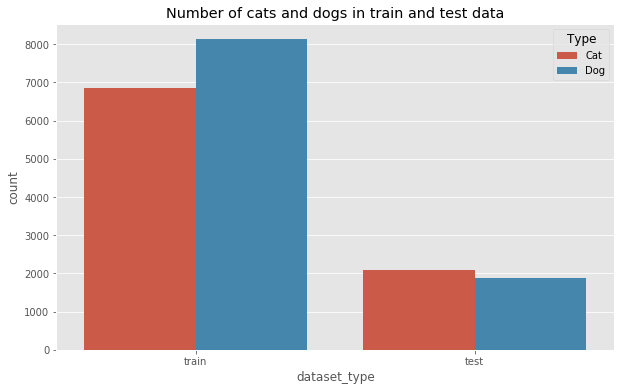

In [17]:
all_data['Type'] = all_data['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')
plt.figure(figsize=(10, 6));
sns.countplot(x='dataset_type', data=all_data, hue='Type');
plt.title('Number of cats and dogs in train and test data');

In [18]:
main_count = train['AdoptionSpeed'].value_counts(normalize=True).sort_index()

In [19]:
def prepare_plot_dict(df, col, main_count):
    """
    Preparing dictionary with data for plotting.
    
    I want to show how much higher/lower are the rates of Adoption speed for the current 
    column comparing to base values (as described higher). At first I calculate base rates, 
    then for each category in the column I calculate rates of Adoption speed and find 
    difference with the base rates.
    """
    main_count = dict(main_count)
    plot_dict = {}
    for i in df[col].unique():
        val_count = dict(df.loc[df[col] == i, 'AdoptionSpeed'].value_counts().sort_index())
        for k, v in main_count.items():
            if k in val_count:
                plot_dict[val_count[k]] = (
                    (val_count[k] / sum(val_count.values())) / main_count[k]
                ) * 100 - 100
            else:
                plot_dict[0] = 0
    return plot_dict

def make_count_plot(df, x, hue='AdoptionSpeed', title='', main_count=main_count):
    """
    Plotting countplot with correct annotations.
    """
    g = sns.countplot(x=x, data=df, hue=hue)
    plt.title('AdoptionSpeed {}'.format(title))
    ax = g.axes
    plot_dict = prepare_plot_dict(df, x, main_count)
    
    for p in ax.patches:
        h = p.get_height() if str(p.get_height()) != 'nan' else 0
        text = ('%.0f' % (plot_dict[h]) if plot_dict[h] < 0 else '+' + '%.0f' % (plot_dict[h])) + '%'
        ax.annotate(
            text, 
            (p.get_x() + p.get_width() / 2., h), 
            ha='center', 
            va='center', 
            fontsize=11, 
            color='green' if plot_dict[h] > 0 else 'red', 
            rotation=0, 
            xytext=(0, 10), 
            textcoords='offset points')

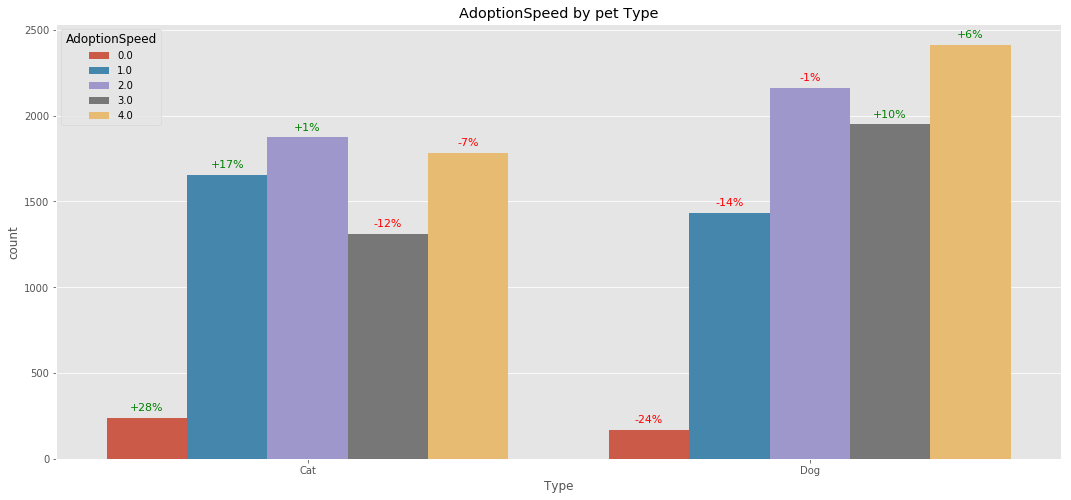

In [20]:
plt.figure(figsize=(18, 8))
make_count_plot(df=all_data.loc[all_data['dataset_type'] == 'train'], x='Type', title='by pet Type')

(-0.5, 1199.5, 999.5, -0.5)

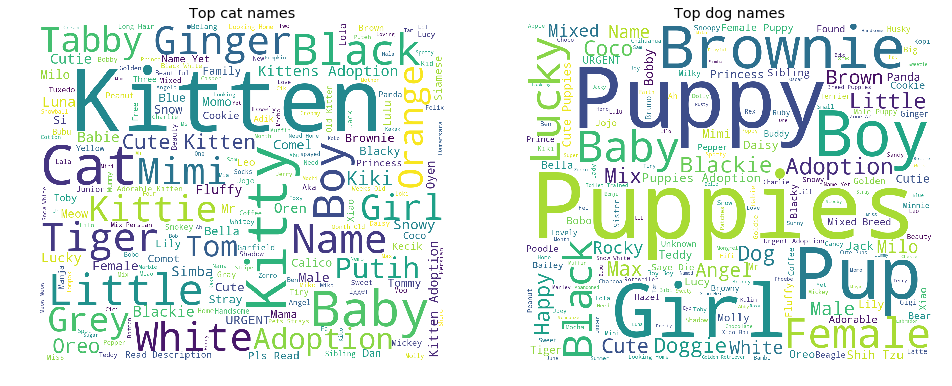

In [21]:
fig, ax = plt.subplots(figsize=(16, 12))
plt.subplot(1, 2, 1)
text_cat = ' '.join(all_data.loc[all_data['Type'] == 'Cat', 'Name'].fillna('').values)
wordcloud = WordCloud(
    max_font_size=None, 
    background_color='white', 
    width=1200, 
    height=1000).generate(text_cat)
plt.imshow(wordcloud)
plt.title('Top cat names')
plt.axis('off')

plt.subplot(1, 2, 2)
text_dog = ' '.join(all_data.loc[all_data['Type'] == 'Dog', 'Name'].fillna('').values)
wordcloud = WordCloud(
    max_font_size=None, 
    background_color='white',
    width=1200,
    height=1000).generate(text_dog)
plt.imshow(wordcloud)
plt.title('Top dog names')
plt.axis('off')

In [22]:
print('Most popular pet names and AdoptionSpeed')
for n in train['Name'].value_counts().index[:5]:
    print(n)
    print(train.loc[train['Name'] == n, 'AdoptionSpeed'].value_counts().sort_index())
    print('')

Most popular pet names and AdoptionSpeed
Baby
0     2
1    11
2    15
3    11
4    27
Name: AdoptionSpeed, dtype: int64

Lucky
0     5
1    14
2    16
3    12
4    17
Name: AdoptionSpeed, dtype: int64

No Name
0     3
1    14
2    11
3     6
4    20
Name: AdoptionSpeed, dtype: int64

Brownie
0     1
1    11
2    14
3    12
4    16
Name: AdoptionSpeed, dtype: int64

Mimi
0     3
1    12
2    13
3     7
4    17
Name: AdoptionSpeed, dtype: int64



In [23]:
train['Name'] = train['Name'].fillna('Unnamed')
test['Name'] = test['Name'].fillna('Unnamed')
all_data['Name'] = all_data['Name'].fillna('Unnamed')

train['No_name'] = 0
train.loc[train['Name'] == 'Unnamed', 'No_name'] = 1
test['No_name'] = 0
test.loc[test['Name'] == 'Unnamed', 'No_name'] = 1
all_data['No_name'] = 0
all_data.loc[all_data['Name'] == 'Unnamed', 'No_name'] = 1

print("Rate of unnamed pets in train data: {}%.".format(
    round(100 * train['No_name'].sum() / train['No_name'].shape[0], 3)))
print("Rate of unnamed pets in test data: {}%.".format(
    round(100 * test['No_name'].sum() / test['No_name'].shape[0], 3)))

Rate of unnamed pets in train data: 8.417%.
Rate of unnamed pets in test data: 7.675%.


In [24]:
 pd.crosstab(train['No_name'], train['AdoptionSpeed'], normalize='index')

AdoptionSpeed         0         1         2         3         4
No_name                                                        
0              0.027966  0.205302  0.271211  0.221470  0.274051
1              0.020602  0.214739  0.248019  0.172742  0.343899

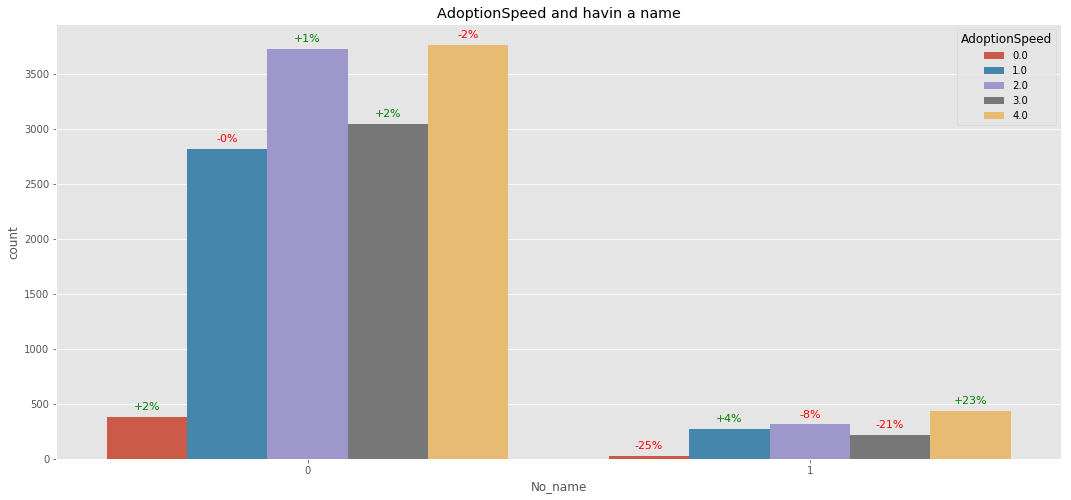

In [25]:
plt.figure(figsize=(18, 8))
make_count_plot(
    df=all_data.loc[all_data['dataset_type'] == 'train'], 
    x='No_name', 
    title='and havin a name'
)

In [26]:
all_data[all_data['Name'].apply(lambda x: len(str(x))) == 3]['Name'].value_counts().tail()

BW3    1
Lix    1
Eve    1
Soy    1
Zee    1
Name: Name, dtype: int64

In [27]:
all_data[all_data['Name'].apply(lambda x: len(str(x))) < 3]['Name'].unique()

array(['H3', 'Z3', 'C', 'BB', 'QQ', 'Y1', 'H1', 'D9', 'Y4', 'Z4', 'DD',
       'M2', 'H6', 'D4', 'JJ', 'F1', 'W7', '1F', 'Q1', '6', 'CJ', '3F',
       'KD', 'G1', 'B3', 'Cc', 'F6', 'Mk', 'A5', 'GM', 'D5', 'EE', 'A4',
       'Q4', 'B', 'CC', 'Y7', 'W6', 'A3', 'A1', 'T1', 'W1', 'M4', 'P5',
       'H2', 'GG', 'Y6', 'Z', 'D7', 'B4', 'C2', 'M8', '3', 'G2', 'ML',
       'DJ', 'PP', '8', 'OJ', 'D', 'F2', 'MJ', 'W8', 'W4', 'C1', 'W2',
       'GR', 'B1', '5', 'Fa', 'Y5', 'M', 'F5', 'Y0', 'B2', 'Q6', 'G3',
       '..', 'S1', 'Qu', 'R9', 'W3', 'R7', 'Tj', 'P3', '7', '!', 'RC',
       'Z2', 'Q3', 'A2', 'QD', 'S', '-', 'R6', 'IV', 'Mo', 'W5', 'F8',
       'M6', 'M9', 'Py', 'Rt', 'F9', 'P6', 'AJ', 'Y3', 'D6', 'T2', 'F4',
       'T3', 'YY', '99', 'F7', 'W+', 'D2', '1', '#1', 'S4', '2', 'Am',
       'P', 'P4', 'R5', 'M3', 'R3', 'JD', 'BJ', 'L', 'KC', 'VV', 'M1',
       '!.', 'V6', 'P1', 'J', 'S3', 'A6', 'Cq', 'M5', 'B5', 'J1', 'O',
       '2F', 'Q2', 'Y2', 'AB', 'A', 'Jo', 'ET', 'A9', 'ST', 'Po', 'KK'

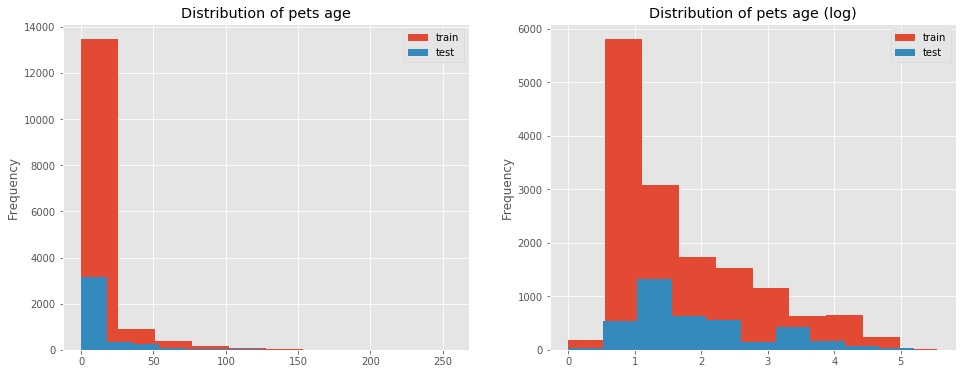

In [28]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.title('Distribution of pets age')
train['Age'].plot('hist', label='train')
test['Age'].plot('hist', label='test')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Distribution of pets age (log)')
np.log1p(train['Age']).plot('hist', label='train')
np.log1p(test['Age']).plot('hist', label='test')
plt.legend()


In [29]:
train['Age'].value_counts().head(10)

2     3503
1     2304
3     1966
4     1109
12     967
24     651
5      595
6      558
36     417
8      309
Name: Age, dtype: int64

Text(0.5, 1.0, 'AdoptionSpeed by Type and age')

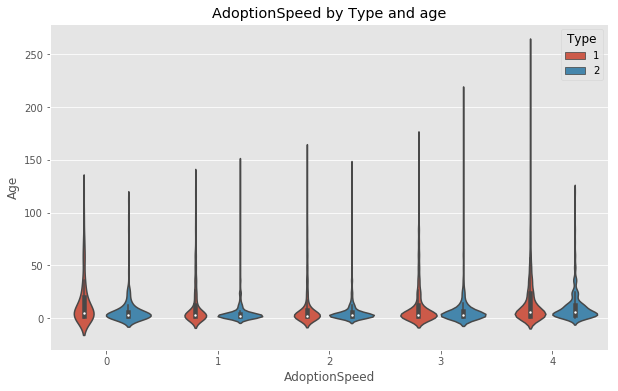

In [30]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='AdoptionSpeed', y='Age', hue='Type', data=train)
plt.title('AdoptionSpeed by Type and age')

In [31]:
data = []
for a in range(5):
    df = train.loc[train['AdoptionSpeed'] == a]
    data.append(go.Scatter(
        x = df['Age'].value_counts().sort_index().index, 
        y = df['Age'].value_counts().sort_index().values, 
        name = str(a)
    ))

layout = go.Layout(dict(title = 'AdoptionSpeed trends by Age', 
                        xaxis = dict(title = 'Age (months)'), 
                        yaxis = dict(title = 'Counts'),
                       )
                  )

py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [32]:
train['Pure_breed'] = 0
train.loc[train['Breed2'] == 0, 'Pure_breed'] = 1
test['Pure_breed'] = 0
test.loc[test['Breed2'] == 0, 'Pure_breed'] = 1
all_data['Pure_breed'] = 0
all_data.loc[all_data['Breed2'] == 0, 'Pure_breed'] = 1

print('Rate of pure breed pets in train data: {}%.'.format(
    round(100 * train['Pure_breed'].sum() / train['Pure_breed'].shape[0], 4)))
print('Rate of pure breed pets in test data: {}%.'.format(
    round(100 * test['Pure_breed'].sum() / test['Pure_breed'].shape[0], 4)))

Rate of pure breed pets in train data: 71.7802%.
Rate of pure breed pets in test data: 77.9635%.


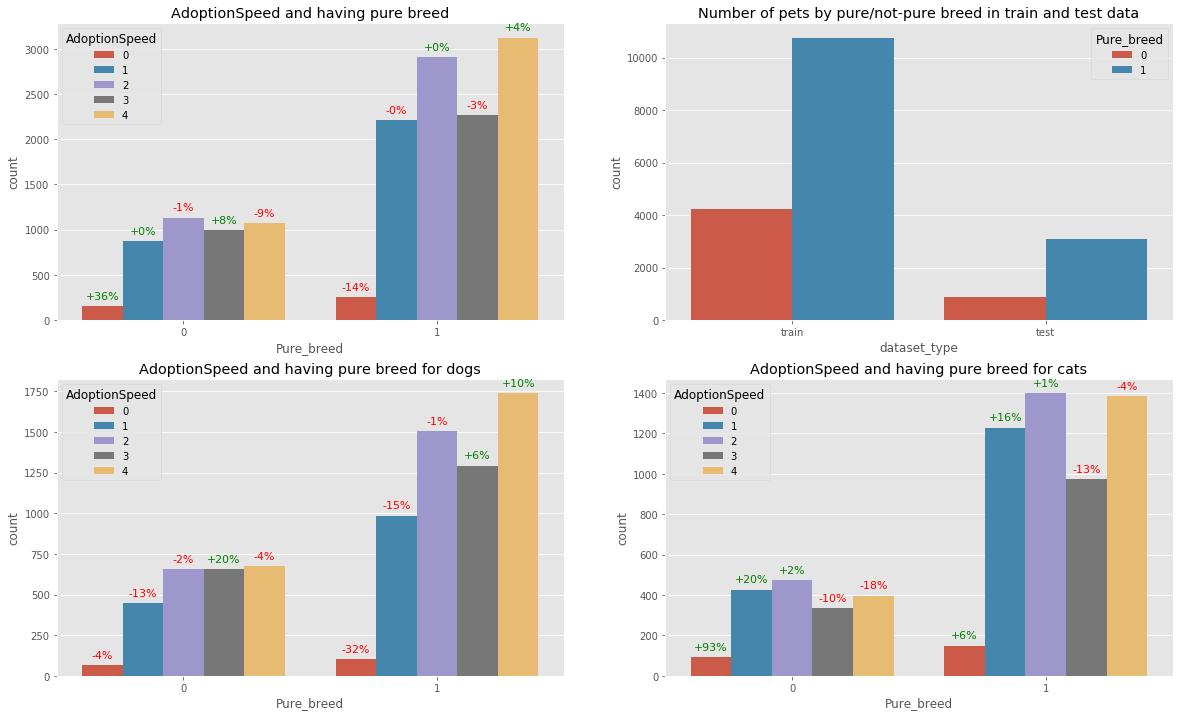

In [33]:
def plot_four_graphs(col='', main_title='', dataset_title=''):
    """
    Plotting four graphs:
    - adoption speed by variable;
    - counts of categories in the variable in train and test;
    - adoption speed by variable for dogs;
    - adoption speed by variable for cats;
    """
    plt.figure(figsize=(20, 12))
    plt.subplot(2, 2, 1)
    make_count_plot(df=train, x=col, title='and {}'.format(main_title))
    
    plt.subplot(2, 2, 2)
    sns.countplot(x='dataset_type', data=all_data, hue=col)
    plt.title(dataset_title)
    
    plt.subplot(2, 2, 3)
    make_count_plot(df=train.loc[train['Type'] == 1], x=col, title='and {} for dogs'.format(main_title))
    
    plt.subplot(2, 2, 4)
    make_count_plot(df=train.loc[train['Type'] == 2], x=col, title='and {} for cats'.format(main_title))
    
plot_four_graphs(col='Pure_breed', main_title='having pure breed', 
                 dataset_title='Number of pets by pure/not-pure breed in train and test data')

In [34]:
breeds_dict = {k: v for k, v in zip(breeds['BreedID'], breeds['BreedName'])}

In [35]:
train['Breed1_name'] = train['Breed1'].apply(
    lambda x: '_'.join(breeds_dict[x].split()) if x in breeds_dict else 'Unknown')
train['Breed2_name'] = train['Breed2'].apply(
    lambda x: '_'.join(breeds_dict[x]) if x in breeds_dict else '-')

test['Breed1_name'] = test['Breed1'].apply(
    lambda x: '_'.join(breeds_dict[x].split()) if x in breeds_dict else 'Unknown')
test['Breed2_name'] = test['Breed2'].apply(
    lambda x: '_'.join(breeds_dict[x].split()) if x in breeds_dict else '-')

all_data['Breed1_name'] = all_data['Breed1'].apply(
    lambda x: '_'.join(breeds_dict[x].split()) if x in breeds_dict else 'Unknown')
all_data['Breed2_name'] = all_data['Breed2'].apply(
    lambda x: '_'.join(breeds_dict[x].split()) if x in breeds_dict else '-')

(-0.5, 1199.5, 999.5, -0.5)

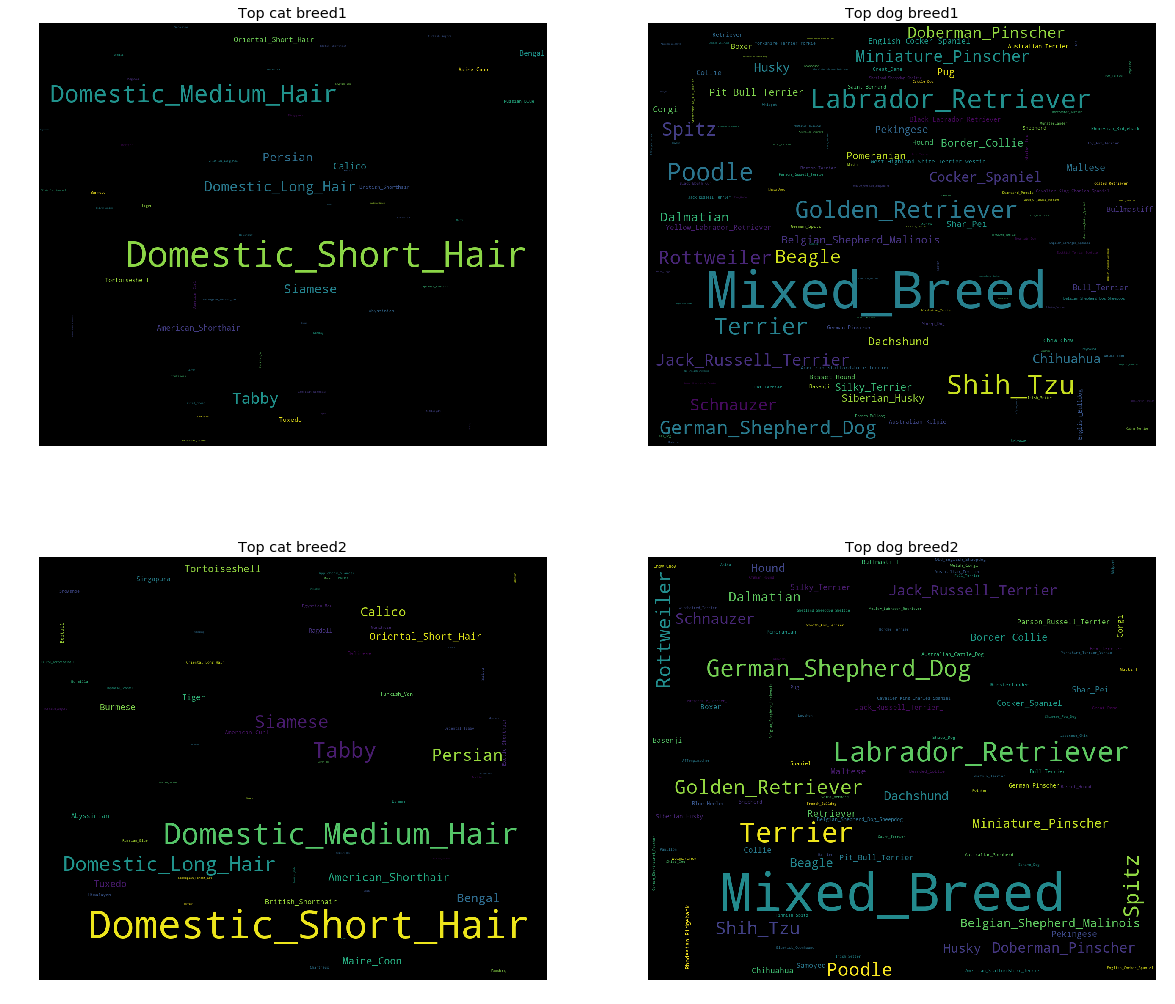

In [36]:
fig, ax = plt.subplots(figsize=(20, 18))
plt.subplot(2, 2, 1)
text_cat1 = ' '.join(all_data.loc[all_data['Type'] == 'Cat', 'Breed1_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False, 
                      width=1200, height=1000).generate(text_cat1)
plt.imshow(wordcloud)
plt.title('Top cat breed1')
plt.axis('off')

plt.subplot(2, 2, 2)
text_dog1 = ' '.join(all_data.loc[all_data['Type'] == 'Dog', 'Breed1_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False, 
                      width=1200, height=1000).generate(text_dog1)
plt.imshow(wordcloud)
plt.title('Top dog breed1')
plt.axis('off')

plt.subplot(2, 2, 3)
text_cat2 = ' '.join(all_data.loc[all_data['Type'] == 'Cat', 'Breed2_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False, 
                      width=1200, height=1000).generate(text_cat2)
plt.imshow(wordcloud)
plt.title('Top cat breed2')
plt.axis('off')

plt.subplot(2, 2, 4)
text_dog2 = ' '.join(all_data.loc[all_data['Type'] == 'Dog', 'Breed2_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False, 
                      width=1200, height=1000).generate(text_dog2)
plt.imshow(wordcloud)
plt.title('Top dog breed2')
plt.axis('off')

In [37]:
(all_data['Breed1_name'] + '__' + all_data['Breed2_name']).value_counts().head(15)

Mixed_Breed__-                                5573
Domestic_Short_Hair__-                        4042
Domestic_Medium_Hair__-                       1264
Mixed_Breed__Mixed_Breed                      1188
Tabby__-                                       379
Domestic_Short_Hair__Domestic_Short_Hair       320
Domestic_Long_Hair__-                          244
Shih_Tzu__-                                    204
Poodle__-                                      153
Siamese__-                                     152
Labrador_Retriever__Mixed_Breed                132
Golden_Retriever__-                            123
Domestic_Medium_Hair__Domestic_Medium_Hair     110
Domestic_Medium_Hair__Domestic_Short_Hair      104
Calico__-                                      101
dtype: int64

Text(0.5, 1.0, 'Number of pets by gender in train and test data')

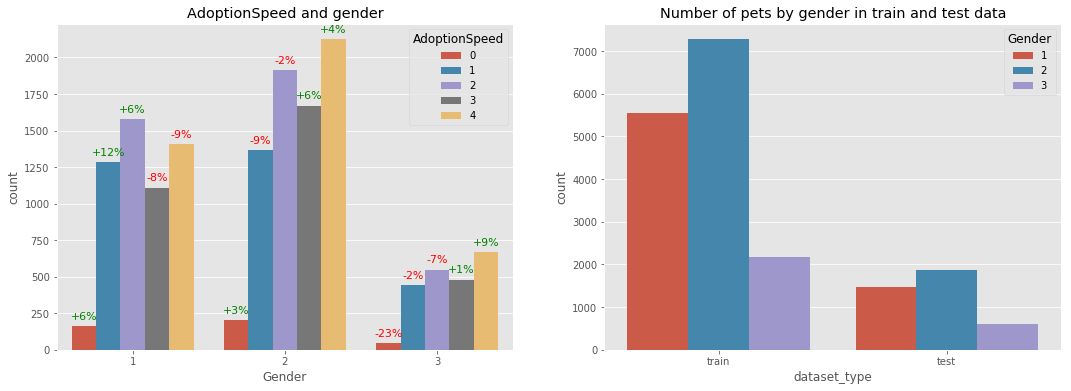

In [38]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
make_count_plot(df=train, x='Gender', title='and gender')

plt.subplot(1, 2, 2)
sns.countplot(x='dataset_type', data=all_data, hue='Gender')
plt.title('Number of pets by gender in train and test data')

Text(0.5, 0.98, 'Count of cats and dogs in train and test set by gender')

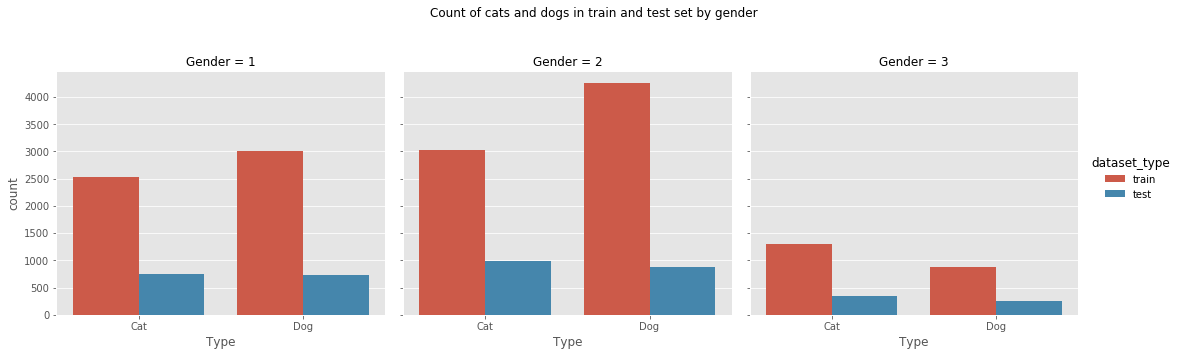

In [39]:
sns.factorplot('Type', col='Gender', data=all_data, kind='count', hue='dataset_type')
plt.subplots_adjust(top=0.8)
plt.suptitle('Count of cats and dogs in train and test set by gender')

In [40]:
colors_dict = {k: v for k, v in zip(colors['ColorID'], colors['ColorName'])}
train['Color1_name'] = train['Color1'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
train['Color2_name'] = train['Color2'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
train['Color3_name'] = train['Color3'].apply(lambda x: colors_dict[x] if x in colors_dict else '')

test['Color1_name'] = test['Color1'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
test['Color2_name'] = test['Color2'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
test['Color3_name'] = test['Color3'].apply(lambda x: colors_dict[x] if x in colors_dict else '')

all_data['Color1_name'] = all_data['Color1'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
all_data['Color2_name'] = all_data['Color2'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
all_data['Color3_name'] = all_data['Color3'].apply(lambda x: colors_dict[x] if x in colors_dict else '')

In [41]:
def make_factor_plot(df, x, col, title, main_count=main_count, hue=None, ann=True, col_wrap=4):
    """
    Plotting countplot.
    Making annotation is a bit more complicated, because we need to interate over axes.
    """
    if hue:
        g = sns.factorplot(col, col=x, data=df, kind='count', col_wrap=col_wrap, hue=hue)
    else:
        g = sns.factorplot(col, col=x, data=df, kind='count', col_wrap=col_wrap)
    
    plt.subplots_adjust(top=0.9)
    plt.suptitle(title)
    ax = g.axes
    plot_dict = prepare_plot_dict(df, x, main_count)
    
    if ann:
        for a in ax:
            for p in a.patches:
                text = (('' if plot_dict[p.get_height()] < 0 else '+') + 
                        str(round(plot_dict[p.get_height()])) + '%')
                a.annotate(text, 
                           (p.get_x() + p.get_width()/2., p.get_height()), 
                           ha='center', 
                           va='center', 
                           fontsize=11, 
                           color='green' if plot_dict[p.get_height()] > 0 else 'red', 
                           rotation=0, 
                           xytext=(0, 10), 
                           textcoords='offset points')

Text(0.5, 0.98, 'Counts of pets in datasets by main color')

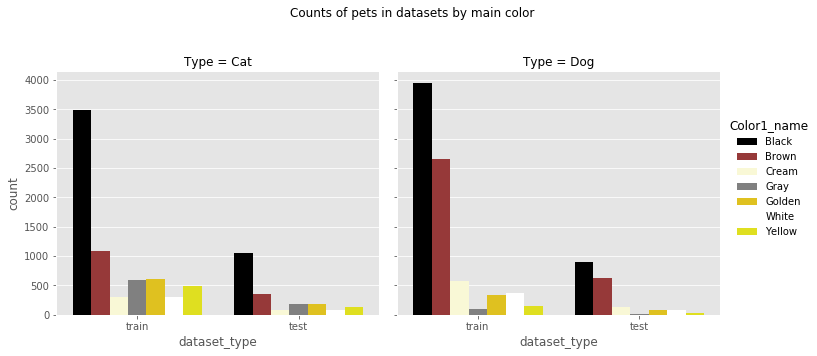

In [42]:
sns.factorplot('dataset_type', col='Type', data=all_data, kind='count', hue='Color1_name', 
               palette=['Black', 'Brown', '#FFFDD0', 'Gray', 'Gold', 'White', 'Yellow'])
plt.subplots_adjust(top=0.8)
plt.suptitle('Counts of pets in datasets by main color')

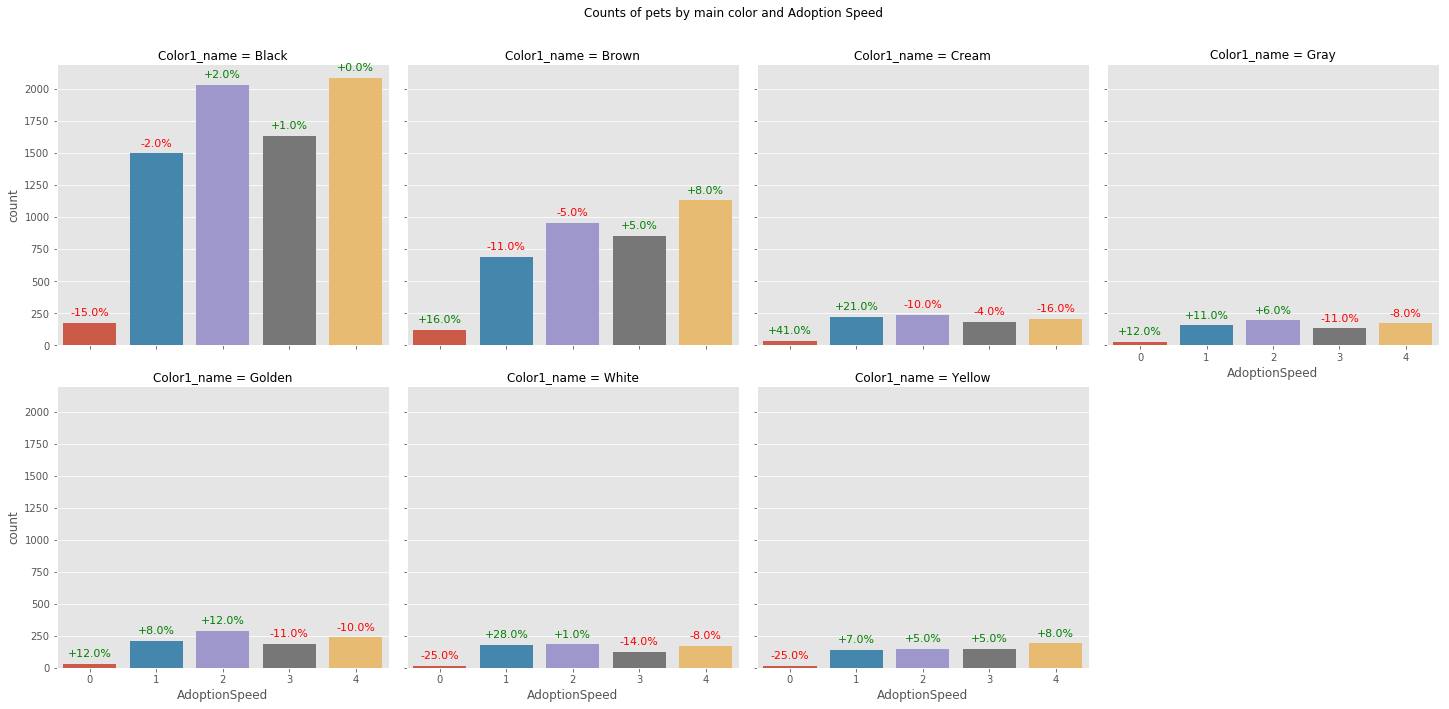

In [43]:
make_factor_plot(df=train, x='Color1_name', col='AdoptionSpeed', 
                 title='Counts of pets by main color and Adoption Speed')

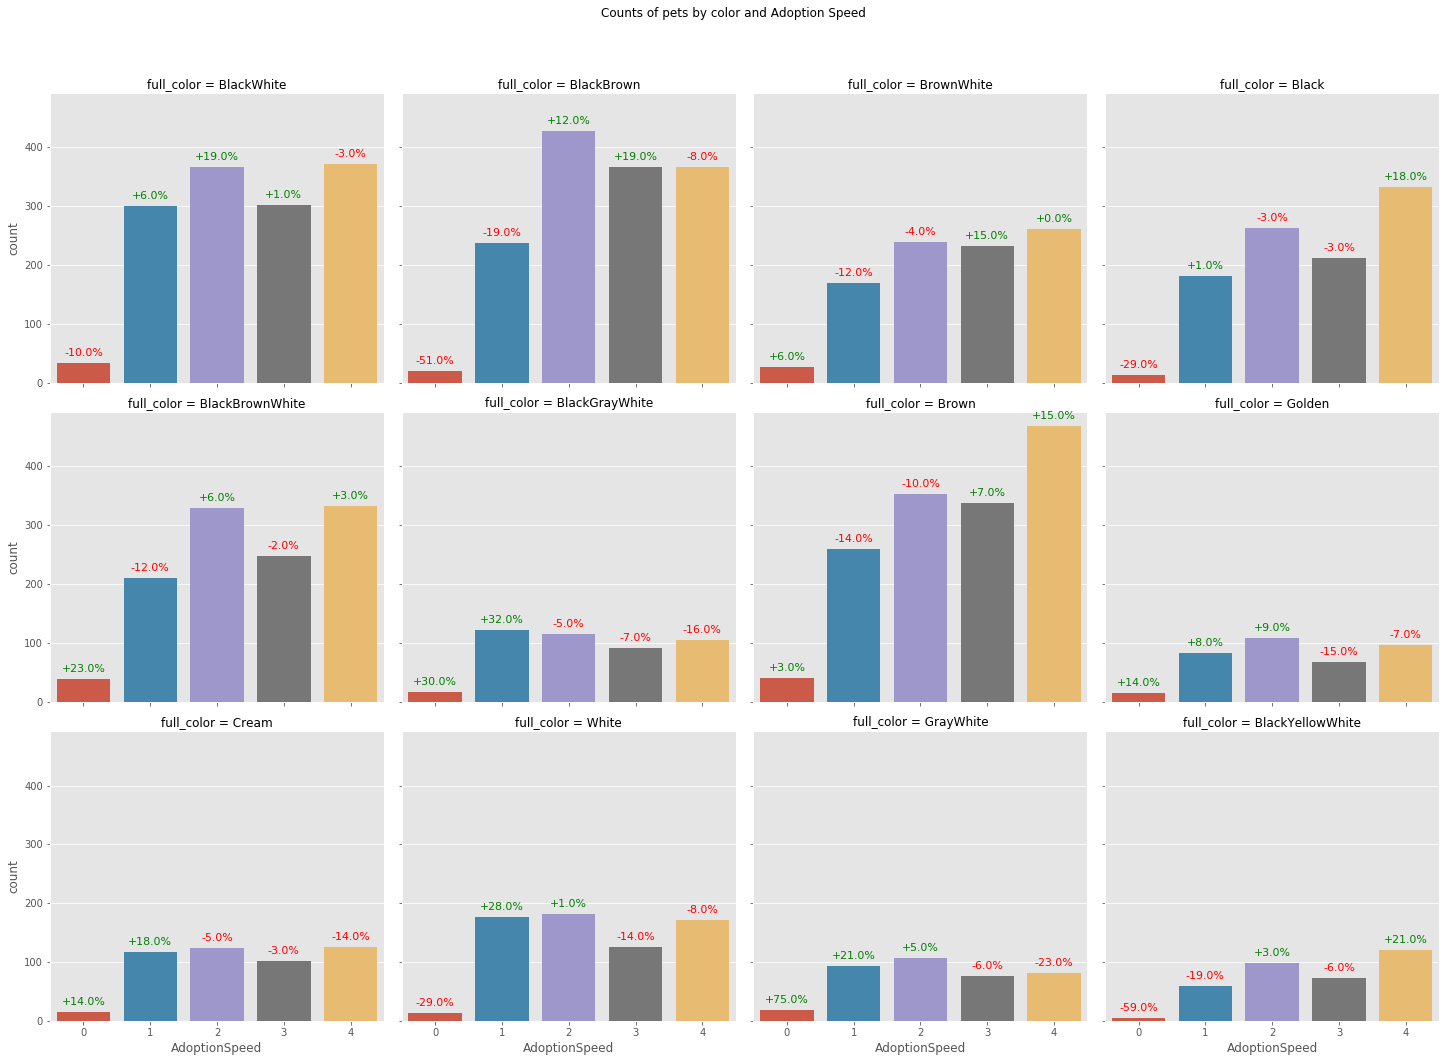

In [44]:
train['full_color'] = (
    train['Color1_name'] + '__' + train['Color2_name'] + '__' + train['Color3_name']
).str.replace('__', '')

test['full_color'] = (
    test['Color1_name'] + '__' + test['Color2_name'] + '__' + test['Color3_name']
).str.replace('__', '')

all_data['full_color'] = (
    all_data['Color1_name'] + '__' + all_data['Color2_name'] + '__' + all_data['Color3_name']
).str.replace('__', '')

make_factor_plot(
    df=train.loc[train['full_color'].isin(
        list(train['full_color'].value_counts().index)[:12])], 
    x='full_color', 
    col='AdoptionSpeed', 
    title='Counts of pets by color and Adoption Speed')

In [45]:
gender_dict = {1: 'Male', 2: 'Female', 3: 'Mixed'}
for i in all_data['Type'].unique():
    for j in all_data['Gender'].unique():
        df = all_data.loc[(all_data['Type'] == i) & (all_data['Gender'] == j)]
        top_colors = list(df['full_color'].value_counts().index)[:5]
        j = gender_dict[j]
        print('Most popular colors of {} {}s: {}'.format(j, i, ' '.join(top_colors)))

Most popular colors of Male Cats: BlackWhite Black GrayWhite YellowWhite BlackGrayWhite
Most popular colors of Female Cats: BlackWhite BlackYellowWhite BlackBrownWhite GrayWhite White
Most popular colors of Mixed Cats: BlackBrownWhite BlackGrayWhite BlackYellowWhite BlackWhite BlackGoldenWhite
Most popular colors of Male Dogs: Brown BlackBrown Black BrownWhite BlackWhite
Most popular colors of Female Dogs: Brown BlackBrown BrownWhite Black BlackWhite
Most popular colors of Mixed Dogs: BlackBrownWhite BlackBrown BlackBrownCream Brown BlackWhite


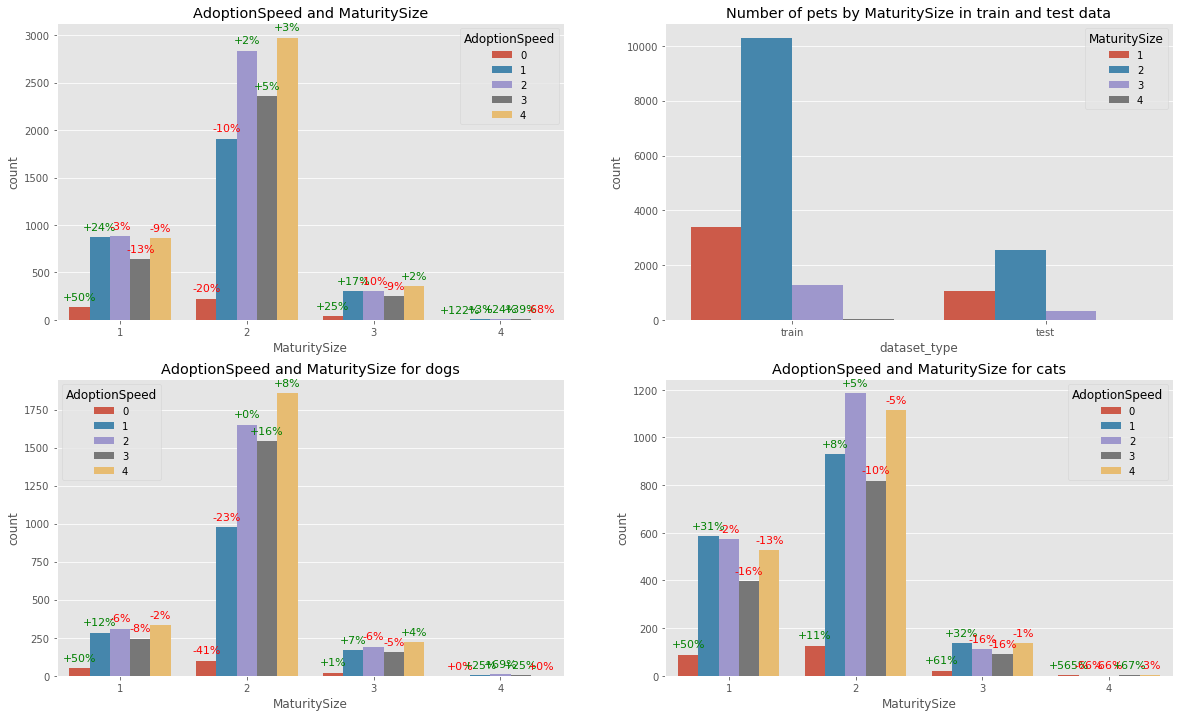

In [46]:
plot_four_graphs(col='MaturitySize', main_title='MaturitySize', 
                 dataset_title='Number of pets by MaturitySize in train and test data')

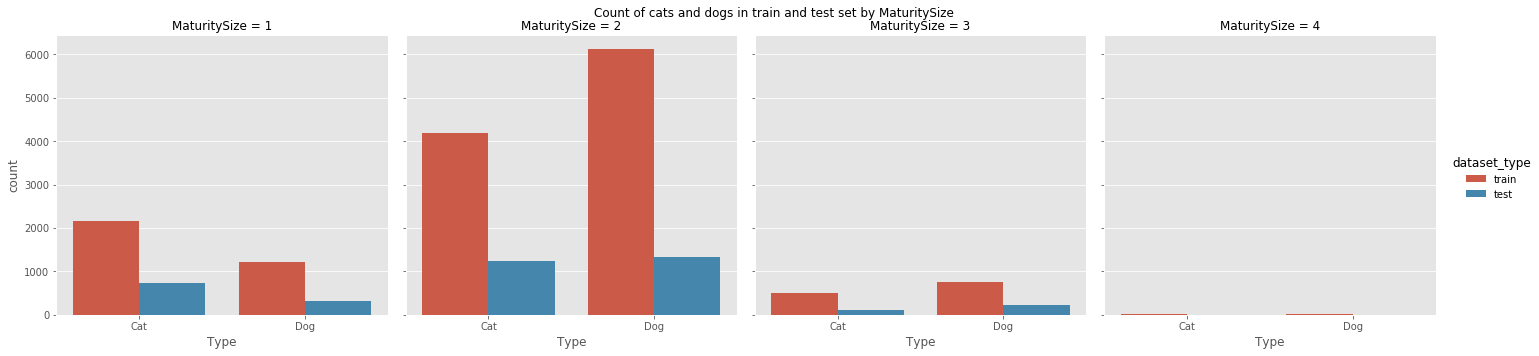

In [47]:
make_factor_plot(df=all_data, x='MaturitySize', col='Type', 
                 title='Count of cats and dogs in train and test set by MaturitySize', 
                 hue='dataset_type', ann=False)

Most common Breeds of Small Cats:


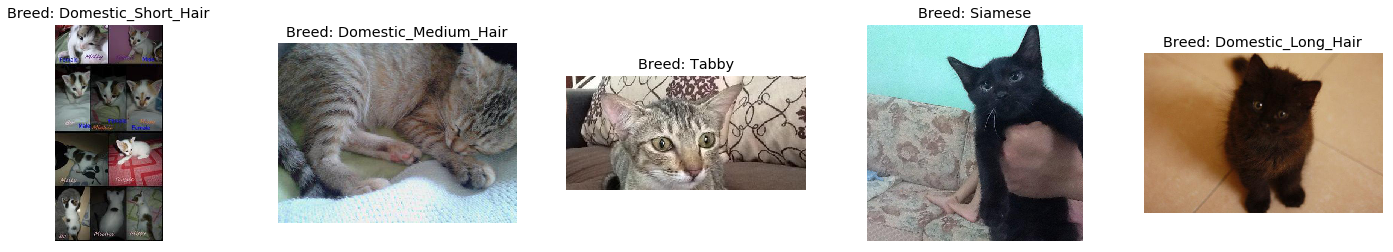

Most common Breeds of Medium Cats:


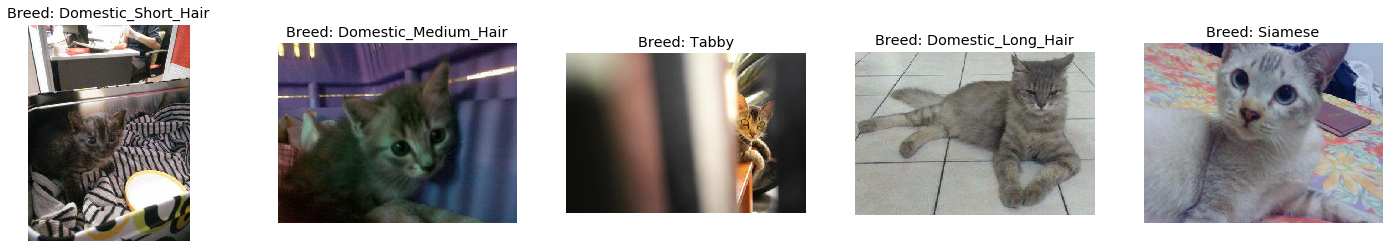

Most common Breeds of Large Cats:


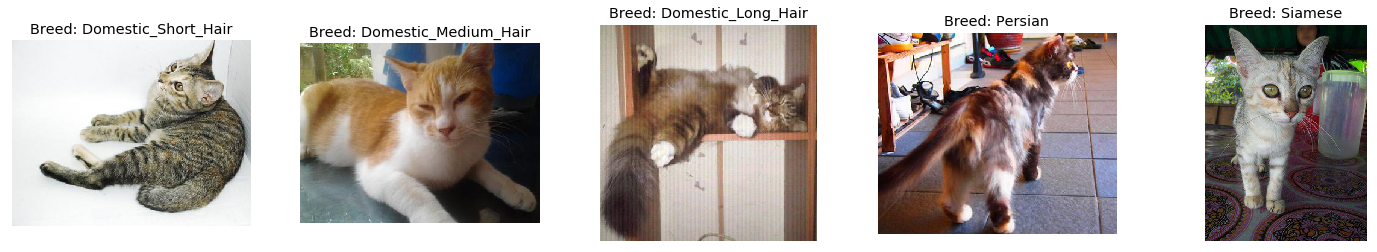

Most common Breeds of Extra Large Cats:


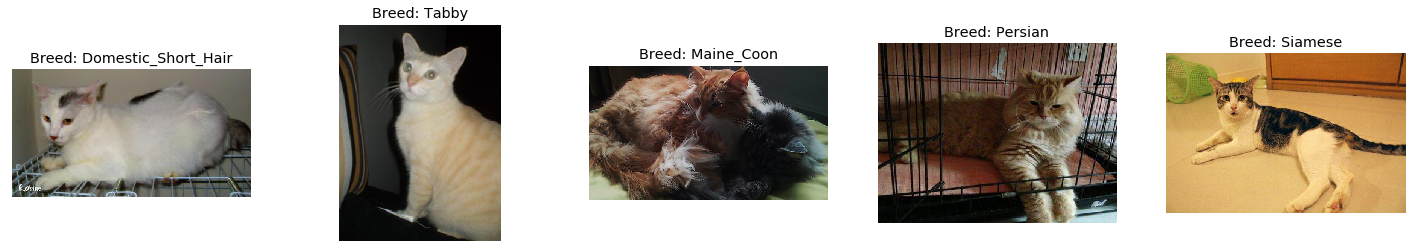

Most common Breeds of Small Dogs:


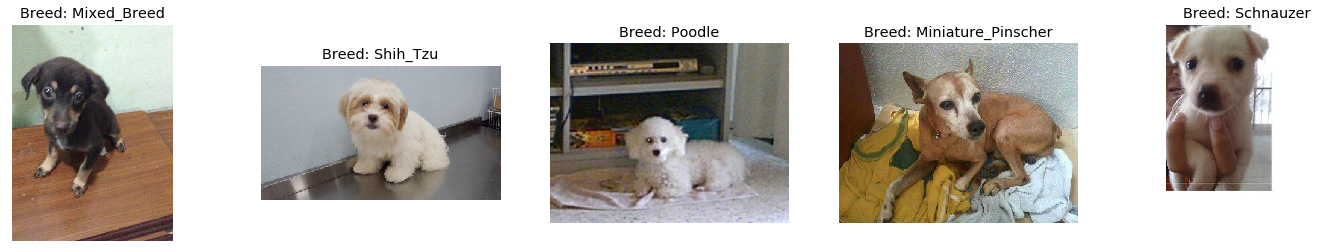

Most common Breeds of Medium Dogs:


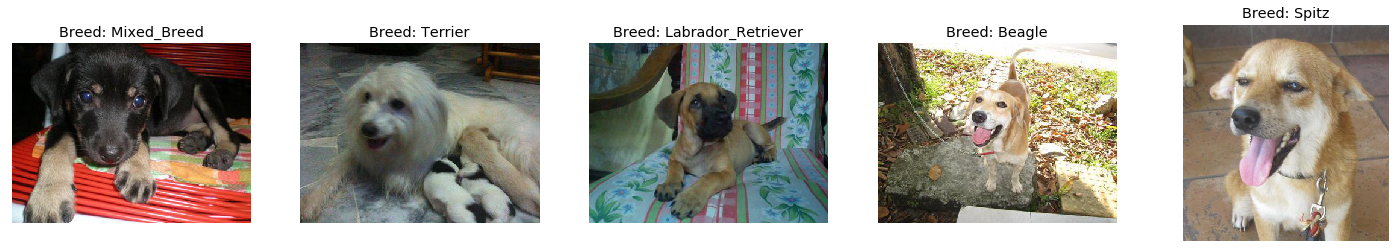

Most common Breeds of Large Dogs:


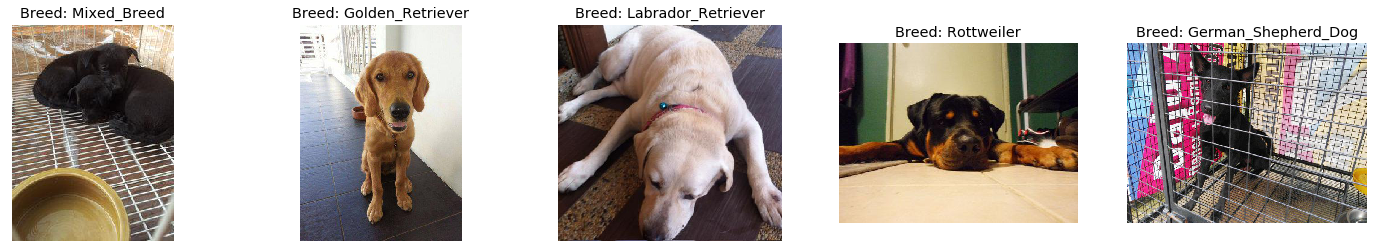

Most common Breeds of Extra Large Dogs:


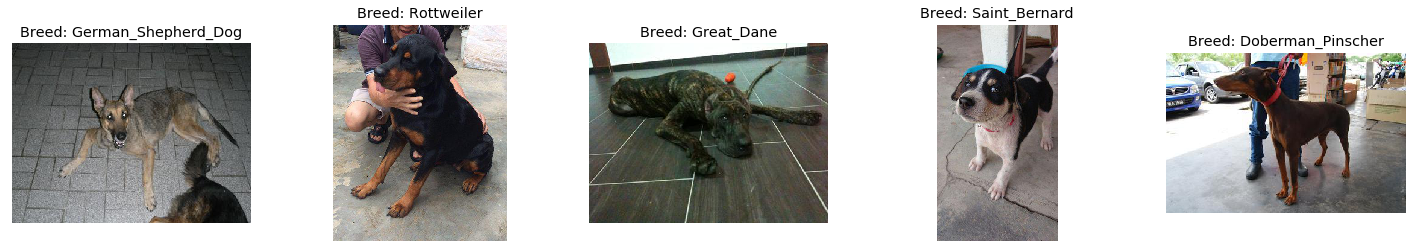

In [48]:
images = [i.split('-')[0] for i in os.listdir('./input/train_images/')]
size_dict = {1: 'Small', 2: 'Medium', 3: 'Large', 4: 'Extra Large'}
for t in all_data['Type'].unique():
    for m in all_data['MaturitySize'].unique():
        df = all_data.loc[(all_data['Type'] == t) & (all_data['MaturitySize'] == m)]
        top_breeds = list(df['Breed1_name'].value_counts().index)[:5]
        m = size_dict[m]
        print('Most common Breeds of {} {}s:'.format(m, t))
        
        fig = plt.figure(figsize=(25, 4))
        
        for i, breed in enumerate(top_breeds):
            # excluding pets without pictures
            b_df = df.loc[(df['Breed1_name'] == breed) & (df['PetID'].isin(images)), 'PetID']

            if len(b_df) > 1:
                pet_id = b_df.values[1]
            else:
                pet_id = b_df.values[0]
            
            ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
            im = Image.open('./input/train_images/' + pet_id + '-1.jpg')
            plt.imshow(im)
            ax.set_title('Breed: {}'.format(breed))
        
        plt.show()

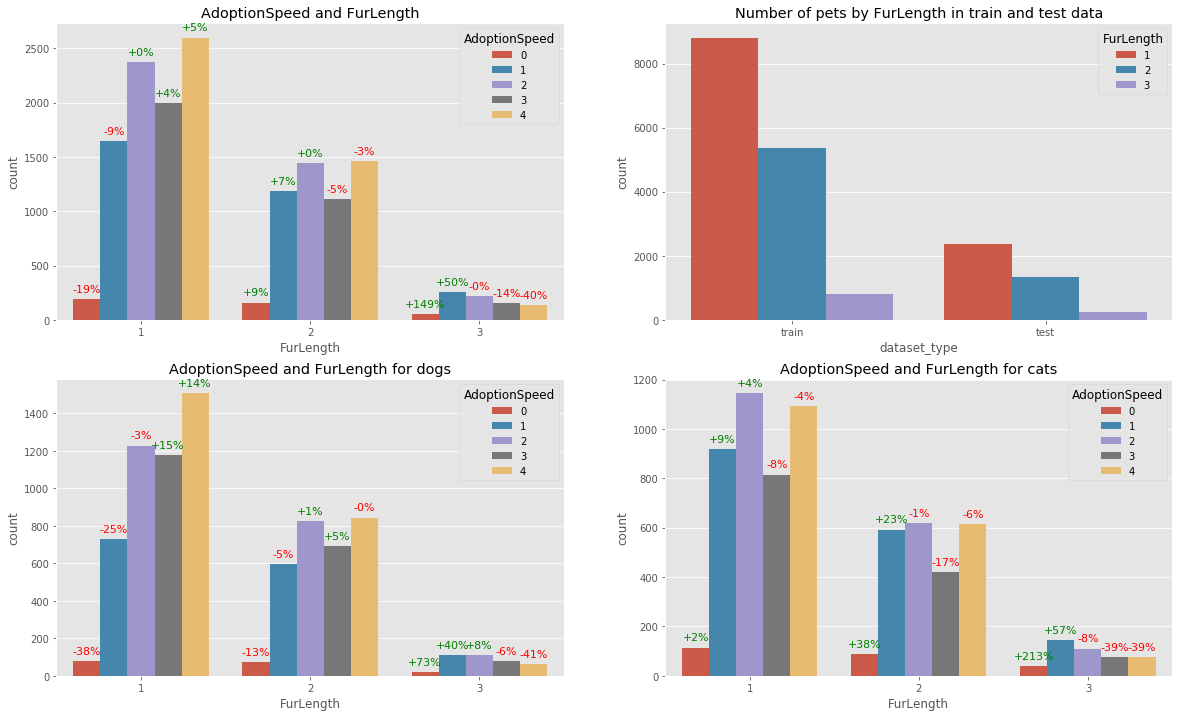

In [49]:
plot_four_graphs(col='FurLength', main_title='FurLength', 
                 dataset_title='Number of pets by FurLength in train and test data')

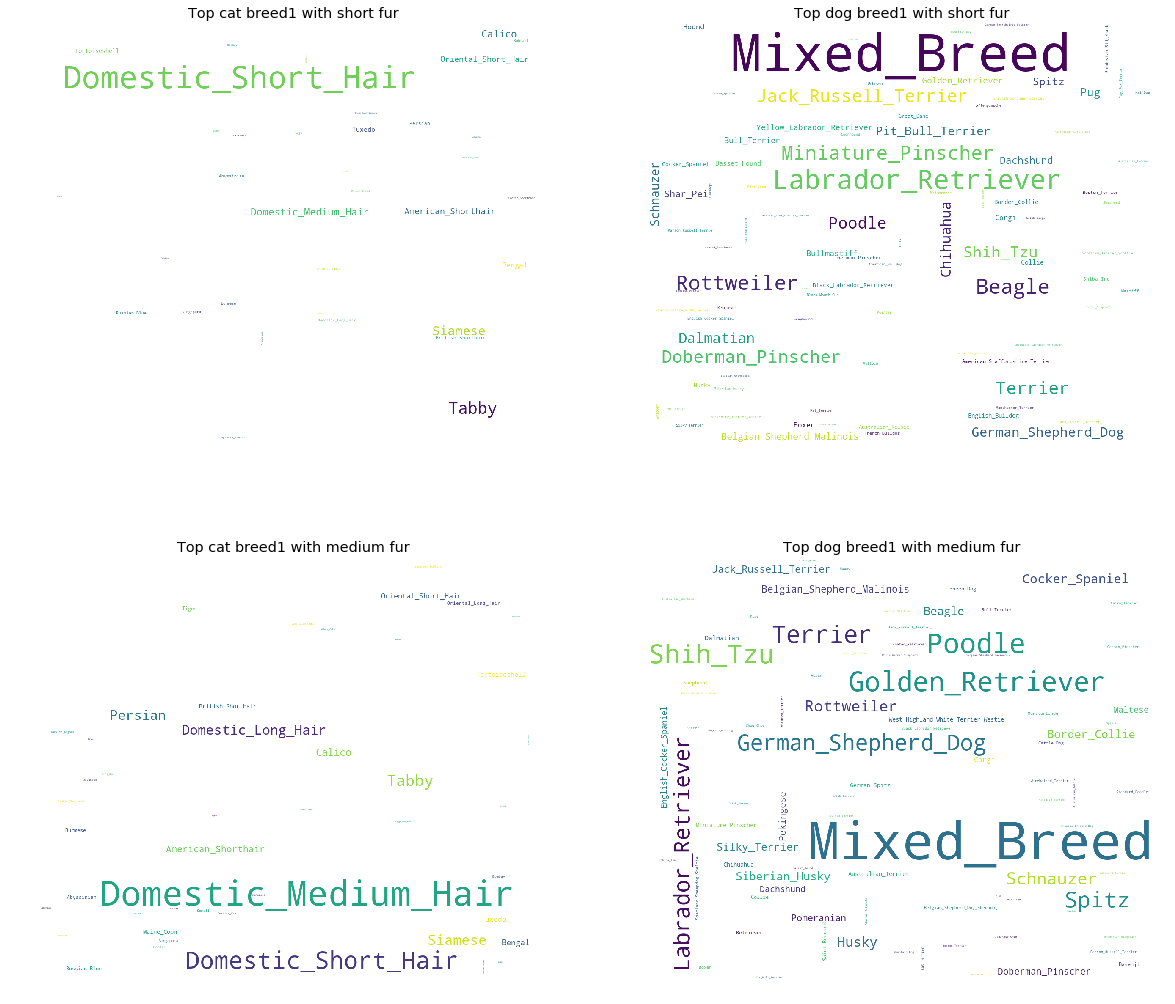

In [50]:
fig, ax = plt.subplots(figsize=(20, 18))

plt.subplot(2, 2, 1)
text_cat1 = ' '.join(
    all_data.loc[(all_data['FurLength'] == 1) & (all_data['Type'] == 'Cat'), 'Breed1_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False, 
                      width=1200, height=1000).generate(text_cat1)
plt.imshow(wordcloud)
plt.title('Top cat breed1 with short fur')
plt.axis('off')

plt.subplot(2, 2, 2)
text_dog1 = ' '.join(
    all_data.loc[(all_data['FurLength'] == 1) & (all_data['Type'] == 'Dog'), 'Breed1_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False, 
                      width=1200, height=1000).generate(text_dog1)
plt.imshow(wordcloud)
plt.title('Top dog breed1 with short fur')
plt.axis('off')

plt.subplot(2, 2, 3)
text_cat1 = ' '.join(
    all_data.loc[(all_data['FurLength'] == 2) & (all_data['Type'] == 'Cat'), 'Breed1_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False, 
                      width=1200, height=1000).generate(text_cat1)
plt.imshow(wordcloud)
plt.title('Top cat breed1 with medium fur')
plt.axis('off')

plt.subplot(2, 2, 4)
text_dog1 = ' '.join(
    all_data.loc[(all_data['FurLength'] == 2) & (all_data['Type'] == 'Dog'), 'Breed1_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False, 
                      width=1200, height=1000).generate(text_dog1)
plt.imshow(wordcloud)
plt.title('Top dog breed1 with medium fur')
plt.axis('off')

plt.show()

In [51]:
c = 0
strange_pets = []
for i, row in all_data[all_data['Breed1_name'].str.contains('air')].iterrows():
    if 'Short' in row['Breed1_name'] and row['FurLength'] == 1:
        pass
    elif 'Medium' in row['Breed1_name'] and row['FurLength'] == 2:
        pass
    elif 'Long' in row['Breed1_name'] and row['FurLength'] == 3:
        pass
    else:
        c += 1
        strange_pets.append((row['PetID'], row['Breed1_name'], row['FurLength']))
print('There are {} pets whose breed and fur length don\'t match'.format(c))

There are 964 pets whose breed and fur length don't match


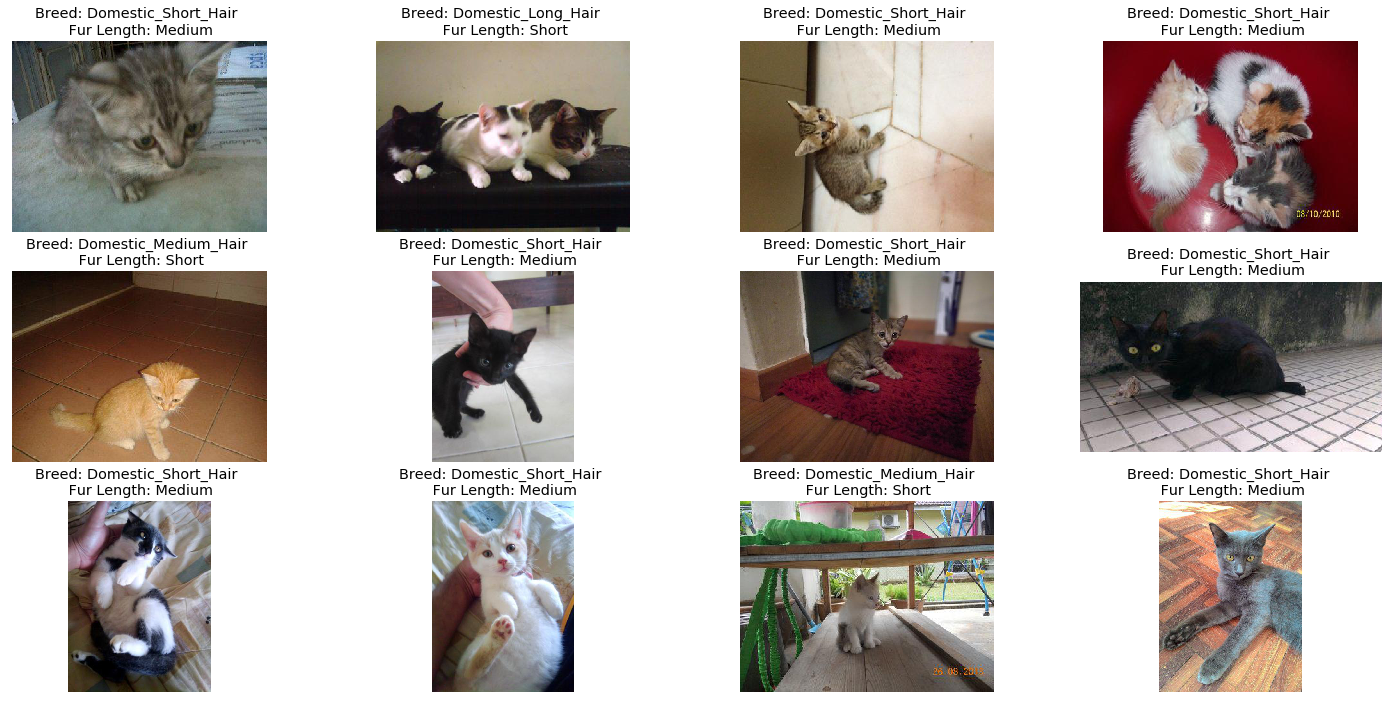

In [52]:
strange_pets = [p for p in strange_pets if p[0] in images]
fig = plt.figure(figsize=(25, 12))
fur_dict = {1: 'Short', 2: 'Medium', 3: 'long'}
for i, s in enumerate(random.sample(strange_pets, 12)):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    im = Image.open('./input/train_images/' + s[0] + '-1.jpg')
    plt.imshow(im)
    ax.set_title('Breed: {} \n Fur Length: {}'.format(s[1], fur_dict[s[2]]))
plt.show()

Text(0.5, 0.98, 'Adoption Speed and health conditions')

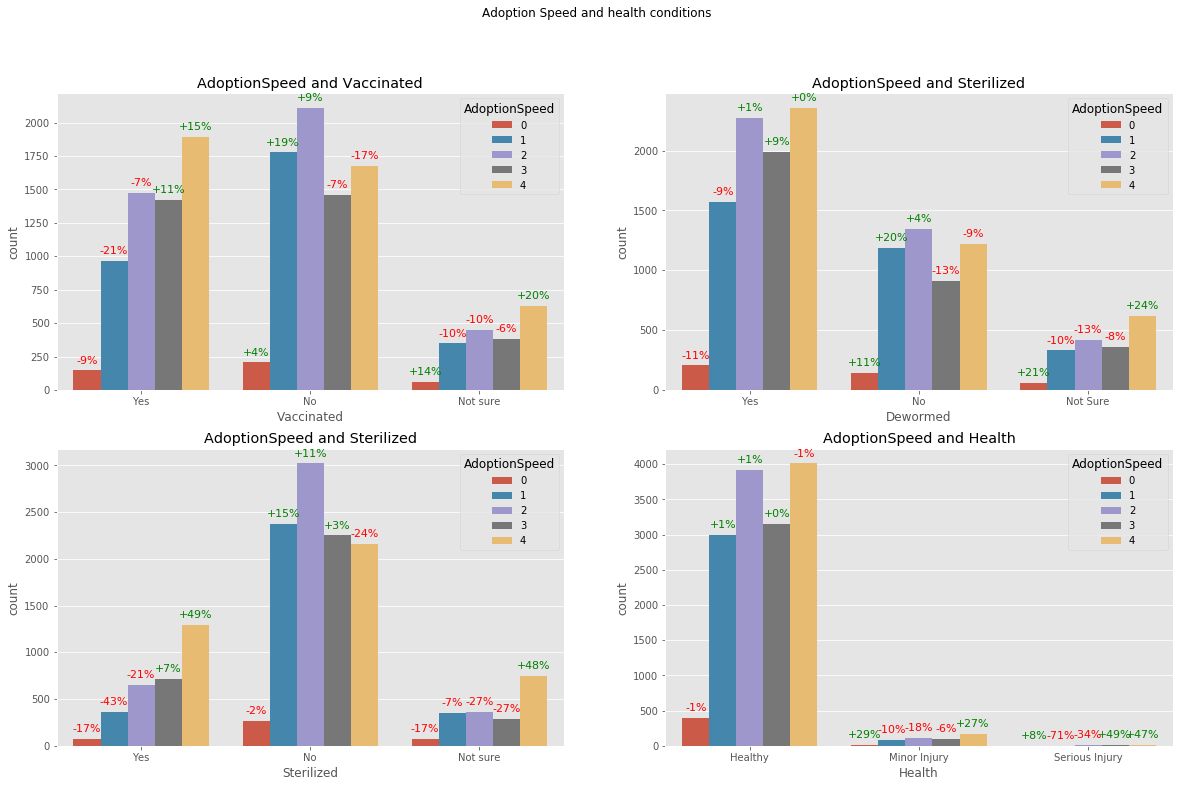

In [53]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
make_count_plot(df=train, x='Vaccinated', title='Vaccinated')
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not sure'])
plt.title('AdoptionSpeed and Vaccinated')

plt.subplot(2, 2, 2)
make_count_plot(df=train, x='Dewormed', title='Dewormed')
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not Sure'])
plt.title('AdoptionSpeed and Sterilized')

plt.subplot(2, 2, 3)
make_count_plot(df=train, x='Sterilized', title='Sterilized')
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not sure'])
plt.title('AdoptionSpeed and Sterilized')

plt.subplot(2, 2, 4)
make_count_plot(df=train, x='Health', title='Health')
plt.xticks([0, 1, 2], ['Healthy', 'Minor Injury', 'Serious Injury'])
plt.title('AdoptionSpeed and Health')

plt.suptitle('Adoption Speed and health conditions')

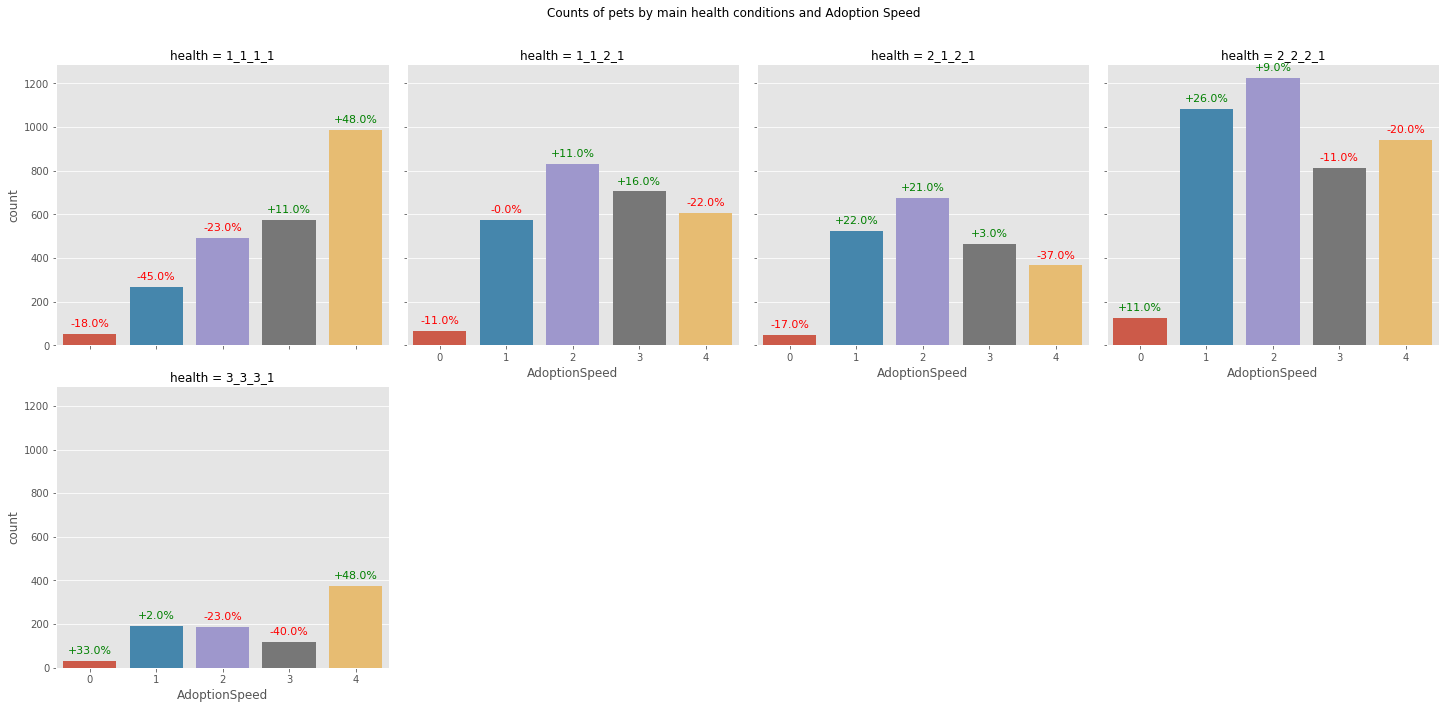

In [54]:
train['health'] = (
    train['Vaccinated'].astype(str) + '_' 
    + train['Dewormed'].astype(str) + '_' 
    + train['Sterilized'].astype(str) + '_' 
    + train['Health'].astype(str)
)
test['health'] = (
    test['Vaccinated'].astype(str) + '_' 
    + test['Dewormed'].astype(str) + '_' 
    + test['Sterilized'].astype(str) + '_' 
    + test['Health'].astype(str)
)
make_factor_plot(
    df=train.loc[train['health'].isin(list(train.health.value_counts().index[:5]))], 
    x='health', col='AdoptionSpeed', 
    title='Counts of pets by main health conditions and Adoption Speed'
)

Text(0.5, 1.0, 'Age distribution by Age and Health')

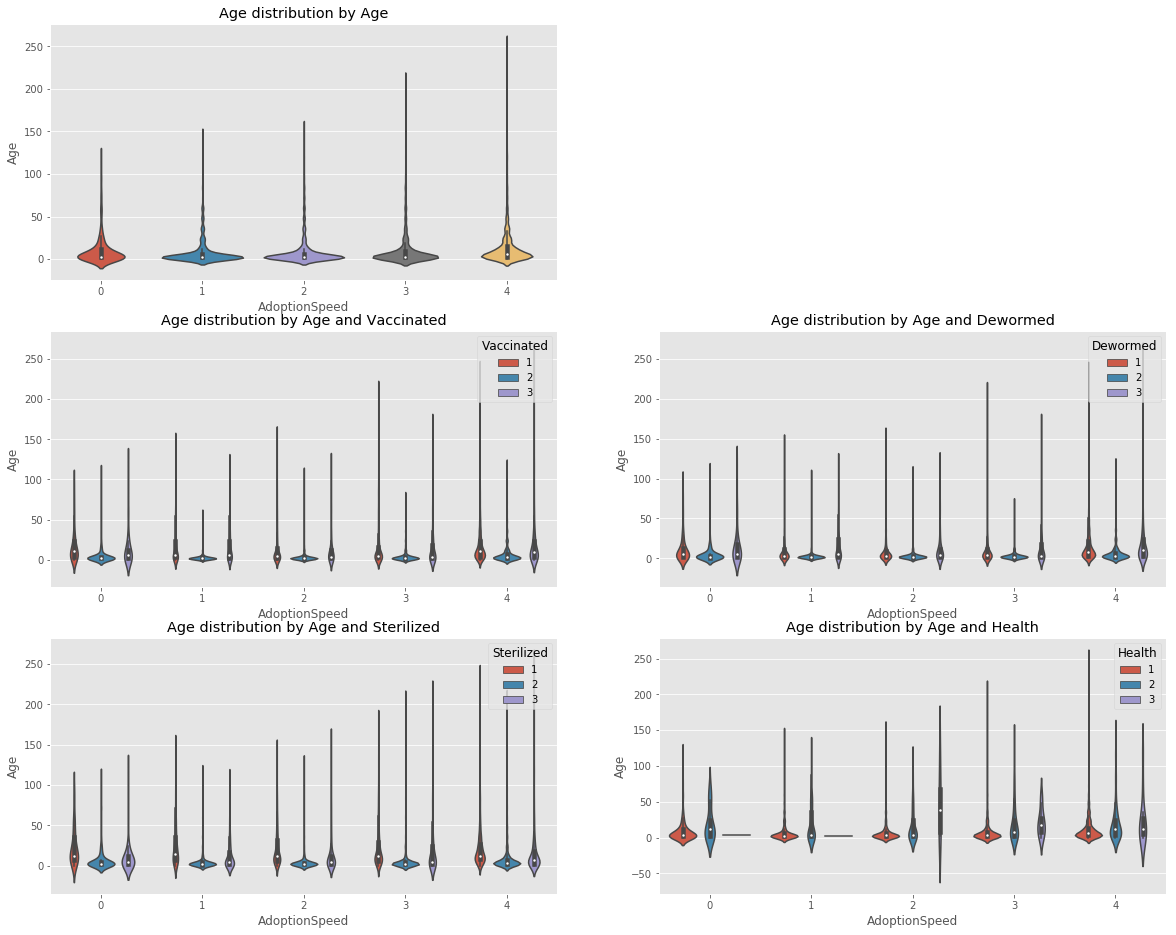

In [55]:
plt.figure(figsize=(20, 16))
plt.subplot(3, 2, 1)
sns.violinplot(x='AdoptionSpeed', y='Age', data=train)
plt.title('Age distribution by Age')
plt.subplot(3, 2, 3)
sns.violinplot(x='AdoptionSpeed', y='Age', hue='Vaccinated', data=train)
plt.title('Age distribution by Age and Vaccinated')
plt.subplot(3, 2, 4)
sns.violinplot(x='AdoptionSpeed', y='Age', hue='Dewormed', data=train)
plt.title('Age distribution by Age and Dewormed')
plt.subplot(3, 2, 5)
sns.violinplot(x='AdoptionSpeed', y='Age', hue='Sterilized', data=train)
plt.title('Age distribution by Age and Sterilized')
plt.subplot(3, 2, 6)
sns.violinplot(x='AdoptionSpeed', y='Age', hue='Health', data=train)
plt.title('Age distribution by Age and Health')

In [56]:
train.loc[train['Quantity'] > 11][['Name', 'Description', 'Quantity', 'AdoptionSpeed']].head(10)

Name  \
263                    20 Little Puppies   
320             18 Cats For NEED HOMES!!   
396    Giant, Cookie & Snoopy. ! Thanks!   
427                         OMIEY'S HOME   
823                        Pancho & Tita   
1302                             Unnamed   
1305                              Bailey   
1404                             Unnamed   
1659  Cats From TTDI Now In Omiey's Home   
2558     ( 0 Puppies Left  )14+2 Puppies   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Description  \
263                                                                                                                                                                                                                                                                                                                              These are 20 puppies, from 2 stray mums need good homes. They are 2 weeks old. If you can give them a good home without caging or chaining, please whatsapp or msg Ms Grace Bong tel no:   
320   YOU can CONTACT the couple at if you are interested. MORE pictures available here: THE HISTORY: They were basically abandoned by their previous owner who left them behind when he moved out. The couple that moved in was left to look after them and has slowly been finding homes for the cats over the last year. There were 28 to begin with and there are 18 left. The last 18 NEED HOMES URGENTLY as the couple is no longer able to care for them. Due to some personal issues, and a new baby then need...   
396   puppies for adoption. Rescued by some good samaritans. No information on breeds, probably mongrels. All about a month old. They have been dewormed but not yet vaccinated. Cookie- female- Smaller than the rest but fiesty! Snoopy- male- Attention seeker. LOVES wagging his tail! Giant- male- Gentle giant. Very soft fur coat! Very playful! Some videos: Giant and his tennis ball- Giant playing with Snoopy- Giant being bullied- ----------------------------------------------------------------------...   
427                                                                                                                                                                                                                                                                                                                                                                        Hi, kepada sesiapa yang berminat untuk adopt kucing-kucing sila hubungi saya . Di sini ada berbagai jenis kucing, dari short hair - long hair.   
823                                                                                                                                                                                                                                                  Pancho and Tita are 2 adorable, playful kittens. They can be shy at first but once they get to know you they are the sweetest pets anyone could ask for. Available for adoption now. They are very, very close so we are looking for someone who can take them both.   
1302                                                                        Sebare Bengal is a specialist catery breeding quality bengal cats. View our web Due to our passion with cats, we have rescued and feed the stray cats until its become healty and ready to go to a new family. Currently, we have 14 DSH ready for adoption from age 3 months to year. 3 male and 11 female. Adoption fee is free but if you kind enough, we will be appreciate if you can donate IAMS Chicken foods for us to feed t

In [57]:
train['Quantity'].value_counts().head(10)

1     11565
2      1422
3       726
4       531
5       333
6       185
7        84
8        52
9        33
10       19
Name: Quantity, dtype: int64

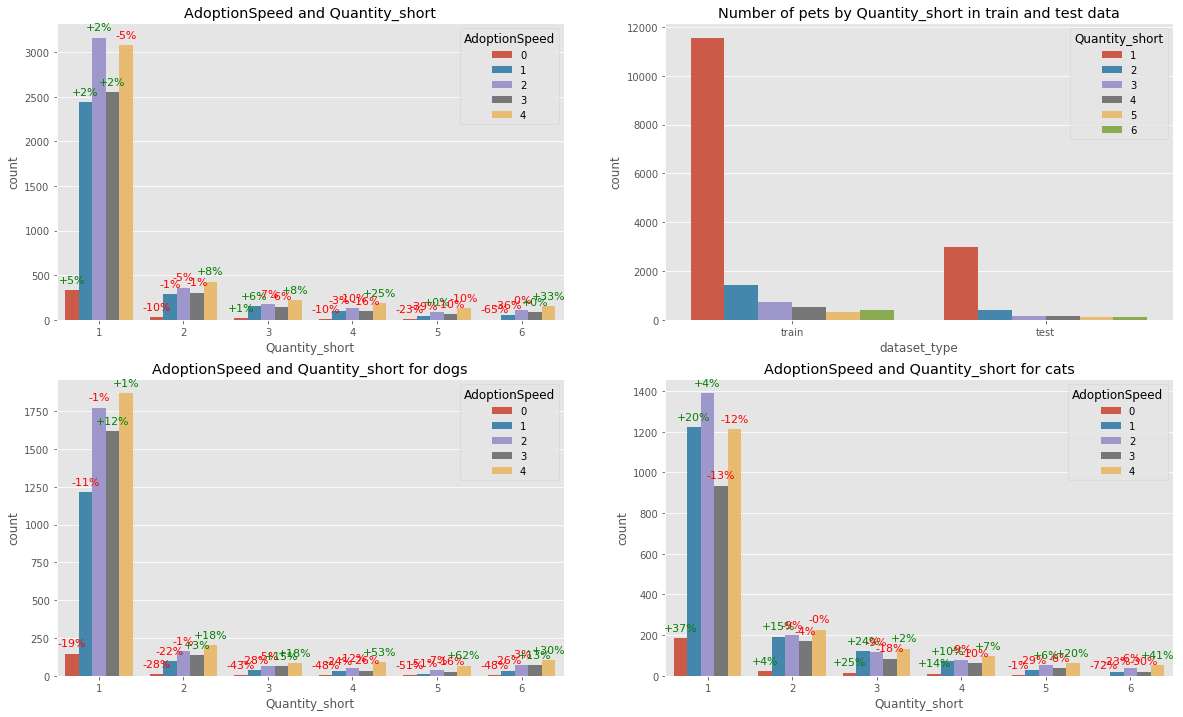

In [58]:
train['Quantity_short'] = train['Quantity'].apply(lambda x: x if x <= 5 else 6)
test['Quantity_short'] = test['Quantity'].apply(lambda x: x if x <= 5 else 6)
all_data['Quantity_short'] = all_data['Quantity'].apply(lambda x: x if x <= 5 else 6)
plot_four_graphs(col='Quantity_short', main_title='Quantity_short', 
                 dataset_title='Number of pets by Quantity_short in train and test data')

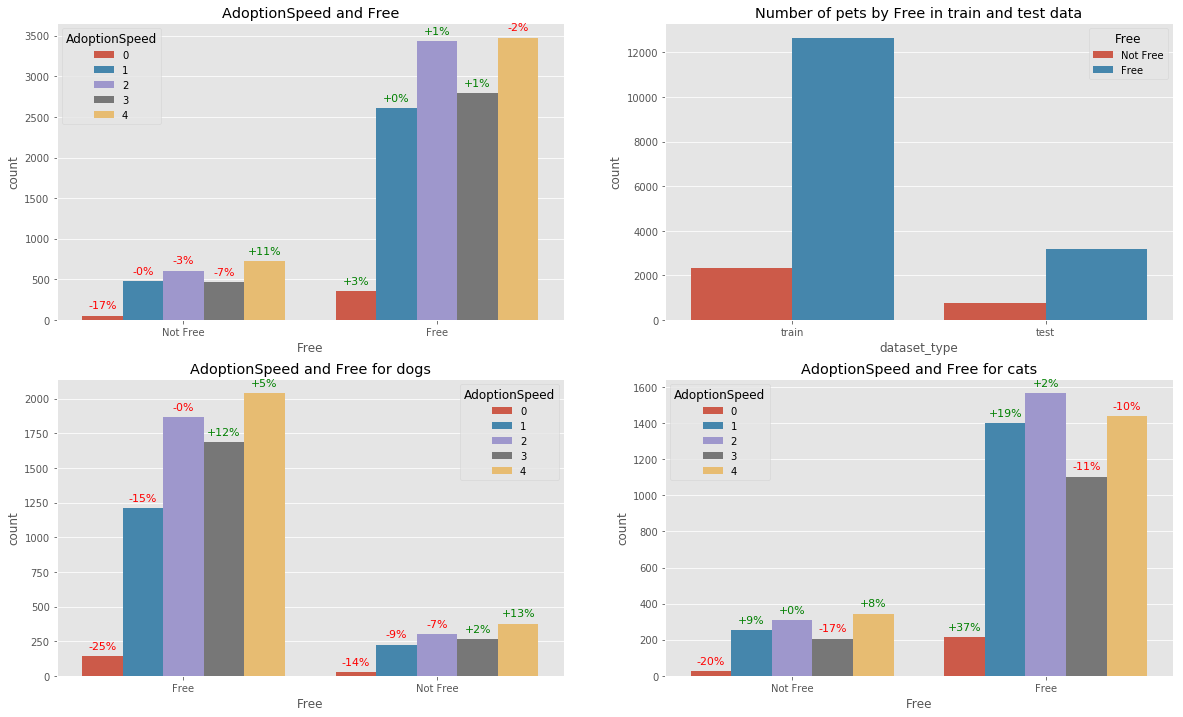

In [59]:
train['Free'] = train['Fee'].apply(lambda x: 'Free' if x == 0 else 'Not Free')
test['Free'] = test['Fee'].apply(lambda x: 'Free' if x == 0 else 'Not Free')
all_data['Free'] = all_data['Fee'].apply(lambda x: 'Free' if x == 0 else 'Not Free')
plot_four_graphs(col='Free', main_title='Free', 
                 dataset_title='Number of pets by Free in train and test data')

In [60]:
all_data.sort_values('Fee', ascending=False)[['Name', 'Description', 'Fee', 'AdoptionSpeed', 'dataset_type']].head(10)

Name  \
8722                 Khaleesi And Drogo   
1604   Fife Registered Exotic Long Hair   
10477                          Bull Dog   
2078              Rottweiler - Adoption   
1792                            NO NAME   
8834                            Adpoted   
8879   Rottweiler Semi-Adult - Adoption   
4844                               Coda   
3425                            Unnamed   
9745                              Oscar   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Description  \
8722   Both pups are family home trained. They love their walks on lead and off lead. Both male and female are from different lineage and both have MKA Reg Certs. They are 4mths and at perfect age for training. The 2pups know some commands like "sit" "outside" "leave" "crate" and more. They are family friendly and can stay/sleep indoors and out. They've just learnt to swim and belly rubs. Great dogs for families that wants a pet and a watchdog too. All vaccines complete, dewormed, microchipped and ...   
1604                                                                                                                                                                                                                                                                                                                                                                                                 -female -5 months -intact( non neuter) -FIFE registerated -vaccinated n dewormed -breeding quality any interested sms   
10477                                                                                     Found this bull dog near my neighbourhood for a month now. I have 3 dogs myself at home. Cannot take care of it. Hopefully if there is someone who is loving who can take care of it. It is very cute and friendly but the saliva keep on drooling. overall there is nothing. forgot to mention, please keep him indoor. He likes to sleep on mattress or sofa, if can please prepare a mattress for him. PLEASE SMS , DONT CALL   
2078                                                                                                                                                                                                                                                                                                                                                               Open for Adoption with Fees Looking for new lovely home due to owner lack of time & care... Vaccination & Deworm up to date Contact me for more details   
1792                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              GOOD BOY   
8834                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               ad

Text(0.5, 1.0, 'AdoptionSpeed by Type and Fee')

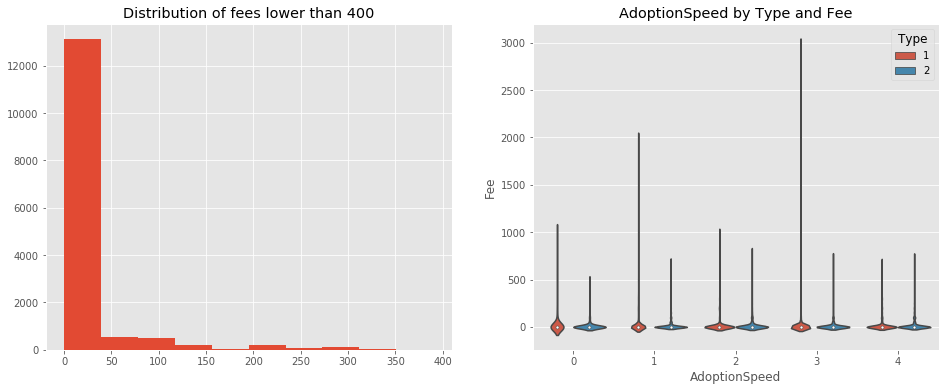

In [61]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.hist(train.loc[train['Fee'] < 400, 'Fee'])
plt.title('Distribution of fees lower than 400')

plt.subplot(1, 2, 2)
sns.violinplot(x='AdoptionSpeed', y='Fee', hue='Type', data=train)
plt.title('AdoptionSpeed by Type and Fee')

Text(0.5, 1.0, 'Quantity of pets and Fee')

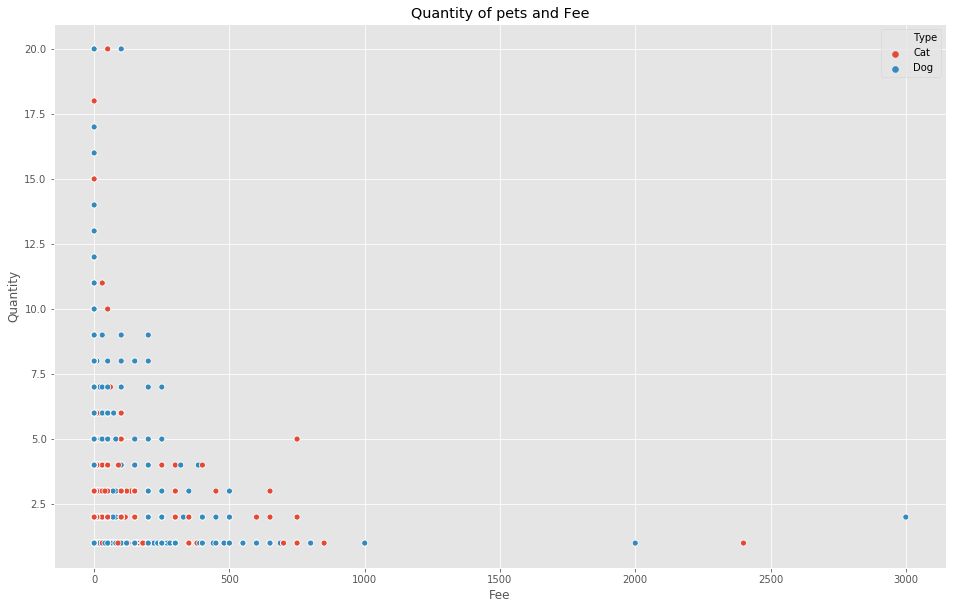

In [62]:
plt.figure(figsize=(16, 10))
sns.scatterplot(x='Fee', y='Quantity', hue='Type', data=all_data)
plt.title('Quantity of pets and Fee')

In [63]:
states_dict = {k: v for k, v in zip(states['StateID'], states['StateName'])}
train['State_name'] = train['State'].apply(
    lambda x: '_'.join(states_dict[x].split()) if x in states_dict else 'Unknown')
test['State_name'] = test['State'].apply(
    lambda x: '_'.join(states_dict[x].split()) if x in states_dict else 'Unknown')
all_data['State_name'] = all_data['State'].apply(
    lambda x: '_'.join(states_dict[x].split()) if x in states_dict else 'Unknown')

In [64]:
all_data['State_name'].value_counts(normalize=True).head()

Selangor        0.566602
Kuala_Lumpur    0.270524
Pulau_Pinang    0.056597
Johor           0.033948
Perak           0.027665
Name: State_name, dtype: float64

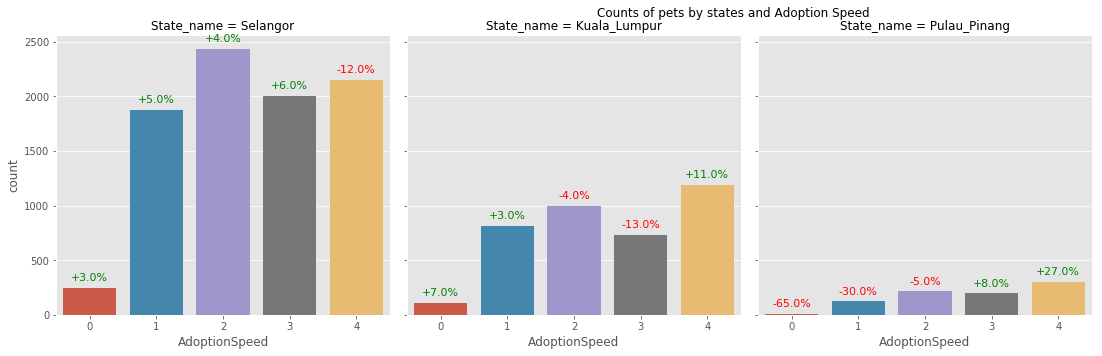

In [65]:
make_factor_plot(
    df=train.loc[train['State_name'].isin(list(train.State_name.value_counts().index[:3]))], 
    x='State_name', col='AdoptionSpeed', 
    title='Counts of pets by states and Adoption Speed'
)

In [66]:
all_data['RescuerID'].value_counts().head()

fa90fa5b1ee11c86938398b60abc32cb    459
aa66486163b6cbc25ea62a34b11c9b91    315
c00756f2bdd8fa88fc9f07a8309f7d5d    231
b53c34474d9e24574bcec6a3d3306a0d    228
ee2747ce26468ec44c7194e7d1d9dad9    156
Name: RescuerID, dtype: int64

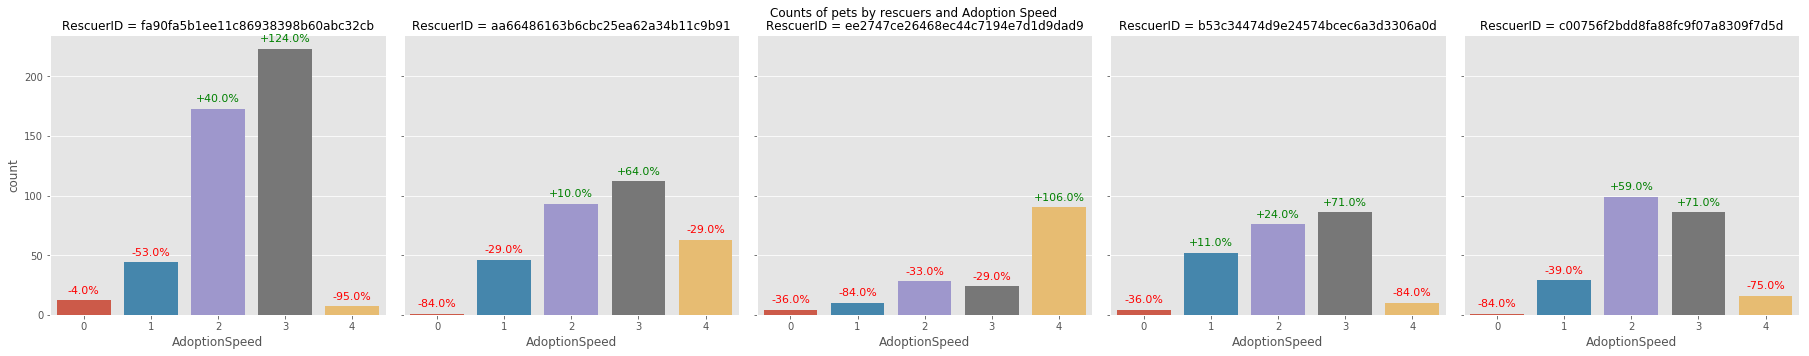

In [67]:
make_factor_plot(
    df=train.loc[train['RescuerID'].isin(list(train.RescuerID.value_counts().index[:5]))], 
    x='RescuerID', col='AdoptionSpeed', title='Counts of pets by rescuers and Adoption Speed', col_wrap=5
)

In [68]:
train['VideoAmt'].value_counts()

0    14419
1      417
2       92
3       36
4       15
5        7
6        4
8        2
7        1
Name: VideoAmt, dtype: int64

In [69]:
print('Maximum amount of photos in {}'.format(train['PhotoAmt'].max()))
train['PhotoAmt'].value_counts().head()

Maximum amount of photos in 30.0


1.0    3075
2.0    2518
3.0    2511
5.0    2147
4.0    1881
Name: PhotoAmt, dtype: int64

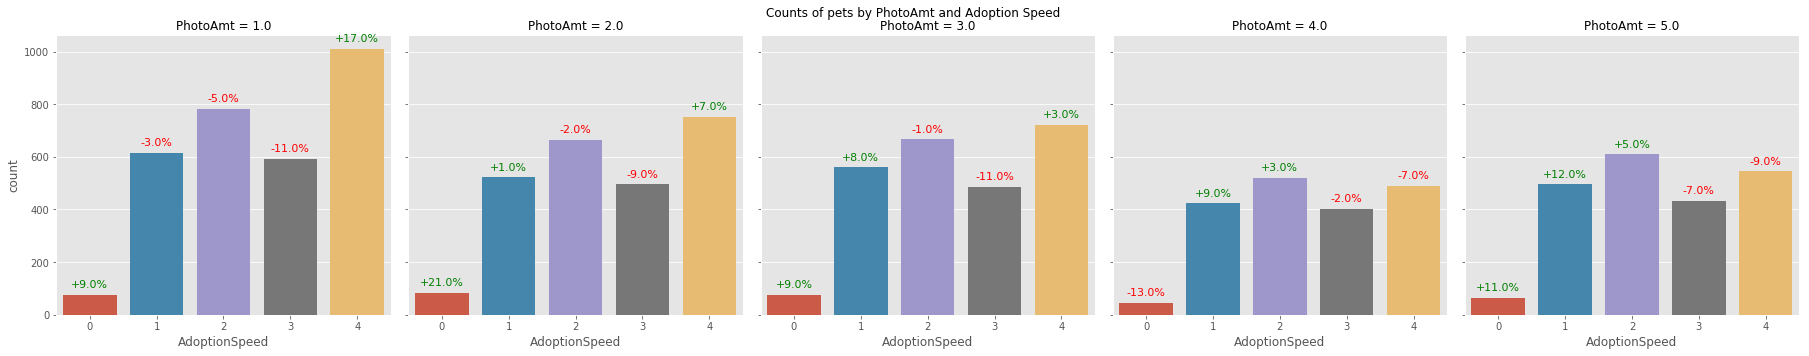

In [70]:
make_factor_plot(
    df=train.loc[train['PhotoAmt'].isin(list(train.PhotoAmt.value_counts().index[:5]))], 
    x='PhotoAmt', col='AdoptionSpeed', title='Counts of pets by PhotoAmt and Adoption Speed', col_wrap=5
)

Text(0.5, 1.0, 'AdoptionSpeed by Type and PhotoAmt')

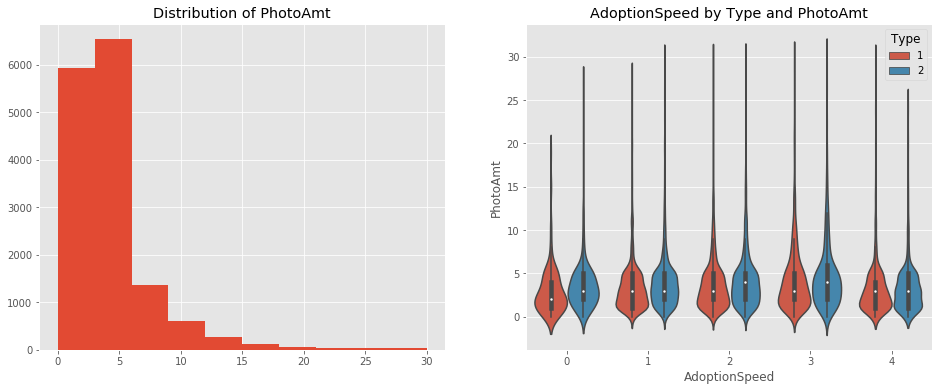

In [71]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['PhotoAmt'])
plt.title('Distribution of PhotoAmt')

plt.subplot(1, 2, 2)
sns.violinplot(x='AdoptionSpeed', y='PhotoAmt', hue='Type', data=train)
plt.title('AdoptionSpeed by Type and PhotoAmt')

(-0.5, 1199.5, 999.5, -0.5)

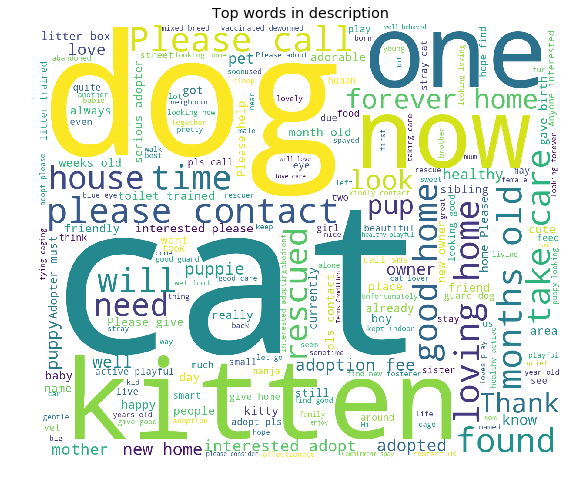

In [72]:
fig, ax = plt.subplots(figsize=(12, 8))
text_cat = ' '.join(all_data['Description'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text_cat)
plt.imshow(wordcloud)
plt.title('Top words in description')
plt.axis('off')

In [73]:
tokenizer = TweetTokenizer()
vectorizer = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tokenizer.tokenize)
vectorizer.fit(all_data['Description'].fillna('').values)
X_train = vectorizer.transform(train['Description'].fillna(''))
rf = RandomForestClassifier(n_estimators=20)
rf.fit(X_train, train['AdoptionSpeed'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [74]:
for i in range(5):
    print('Example of Adoption speed {}'.format(i))
    text = train.loc[train['AdoptionSpeed'] == i, 'Description'].values[0]
    print(text)
    display(eli5.show_prediction(rf, doc=text, vec=vectorizer, top=10))

Example of Adoption speed 0
I just found it alone yesterday near my apartment. It was shaking so I had to bring it home to provide temporary care.


Example of Adoption speed 1
anyone within the area of ipoh or taiping who interested to adopt my cat can contact my father at this number (mazuvil)or can just email me. currently bulat is at my hometown at perak but anyone outside the area still want to adopt can travel there to my hometown.there is a lot of cats in my house rite now..i think i should let one of them go to a better owner who can give better attention to him.


Example of Adoption speed 2
Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.


Example of Adoption speed 3
Their pregnant mother was dumped by her irresponsible owner at the roadside near some shops in Subang Jaya. Gave birth to them at the roadside. They are all healthy and adorable puppies. Already dewormed, vaccinated and ready to go to a home. No tying or caging for long hours as guard dogs. However, it is acceptable to cage or tie for precautionary purposes. Interested to adopt pls call me.


Example of Adoption speed 4
Very manja and gentle stray cat found, we would really like to find a home for it because we cannot keep her for ourselves for long. Has a very cute high pitch but soft meow. Please contact me if you would be interested in adopting.


In [75]:
train['Description'] = train['Description'].fillna('')
test['Description'] = test['Description'].fillna('')
all_data['Description'] = all_data['Description'].fillna('')

train['desc_length'] = train['Description'].apply(lambda x: len(x))
train['desc_words'] = train['Description'].apply(lambda x: len(x.split()))

test['desc_length'] = test['Description'].apply(lambda x: len(x))
test['desc_words'] = test['Description'].apply(lambda x: len(x.split()))

all_data['desc_length'] = all_data['Description'].apply(lambda x: len(x))
all_data['desc_words'] = all_data['Description'].apply(lambda x: len(x.split()))

train['average_word_length'] = train['desc_length'] / train['desc_words']
test['average_word_length'] = test['desc_length'] / test['desc_words']
all_data['average_word_length'] = all_data['desc_length'] / all_data['desc_words']

Text(0.5, 1.0, 'AdoptionSpeed by Type and count of words in description')

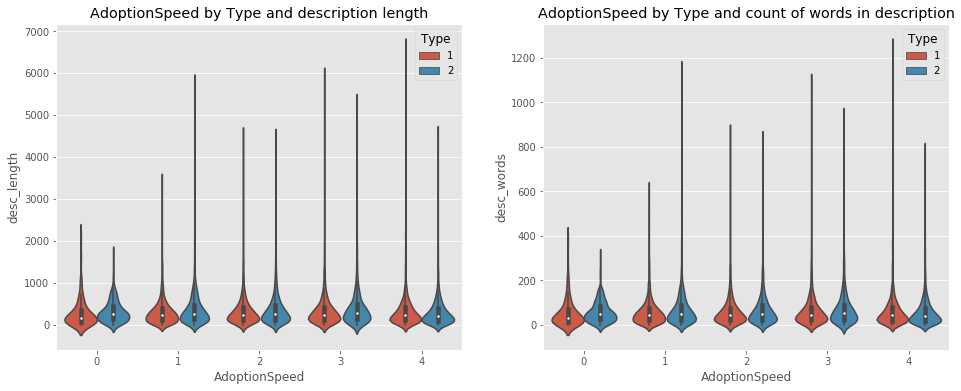

In [76]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.violinplot(x='AdoptionSpeed', y='desc_length', hue='Type', data=train)
plt.title('AdoptionSpeed by Type and description length')

plt.subplot(1, 2, 2)
sns.violinplot(x='AdoptionSpeed', y='desc_words', hue='Type', data=train)
plt.title('AdoptionSpeed by Type and count of words in description')

In [77]:
sentiment_dict = {}
for filename in os.listdir('./input/train_sentiment/'):
    with open('./input/train_sentiment/' + filename, 'r', encoding='utf-8') as f:
        sentiment = json.load(f)
    pet_id = filename.split('.')[0]
    sentiment_dict[pet_id] = {}
    sentiment_dict[pet_id]['magnitude'] = sentiment['documentSentiment']['magnitude']
    sentiment_dict[pet_id]['score'] = sentiment['documentSentiment']['score']
    sentiment_dict[pet_id]['language'] = sentiment['language']
    
for filename in os.listdir('./input/test_sentiment/'):
    with open('./input/test_sentiment/' + filename, 'r', encoding='utf-8') as f:
        sentiment = json.load(f)
    pet_id = filename.split('.')[0]
    sentiment_dict[pet_id] = {}
    sentiment_dict[pet_id]['magnitude'] = sentiment['documentSentiment']['magnitude']
    sentiment_dict[pet_id]['score'] = sentiment['documentSentiment']['score']
    sentiment_dict[pet_id]['language'] = sentiment['language']

In [78]:
train['lang'] = train['PetID'].apply(lambda x: sentiment_dict[x]['language'] if x in sentiment_dict else 'no')
train['magnitude'] = train['PetID'].apply(lambda x: sentiment_dict[x]['magnitude'] if x in sentiment_dict else 0)
train['score'] = train['PetID'].apply(lambda x: sentiment_dict[x]['score'] if x in sentiment_dict else 0)

test['lang'] = test['PetID'].apply(lambda x: sentiment_dict[x]['language'] if x in sentiment_dict else 'no')
test['magnitude'] = test['PetID'].apply(lambda x: sentiment_dict[x]['magnitude'] if x in sentiment_dict else 0)
test['score'] = test['PetID'].apply(lambda x: sentiment_dict[x]['score'] if x in sentiment_dict else 0)

all_data['lang'] = all_data['PetID'].apply(lambda x: sentiment_dict[x]['language'] if x in sentiment_dict else 'no')
all_data['magnitude'] = all_data['PetID'].apply(lambda x: sentiment_dict[x]['magnitude'] if x in sentiment_dict else 0)
all_data['score'] = all_data['PetID'].apply(lambda x: sentiment_dict[x]['score'] if x in sentiment_dict else 0)

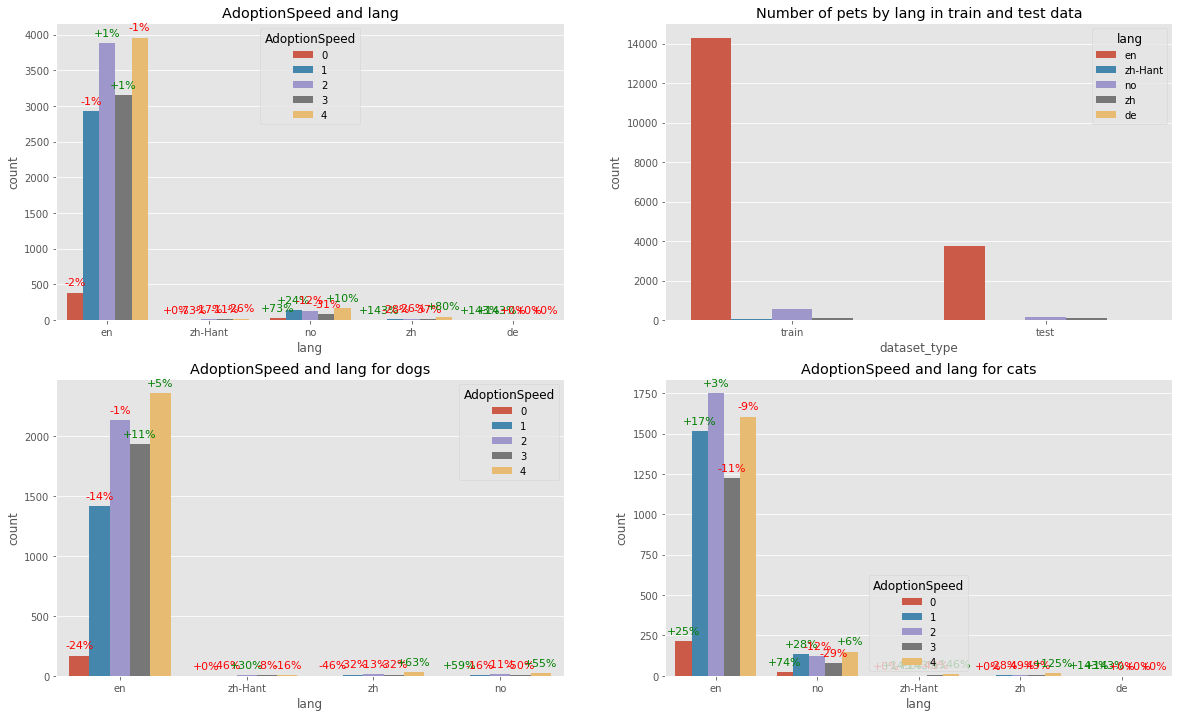

In [79]:
plot_four_graphs(col='lang', main_title='lang', dataset_title='Number of pets by lang in train and test data')

Text(0.5, 1.0, 'AdoptionSpeed by Type and magnitude of sentiment')

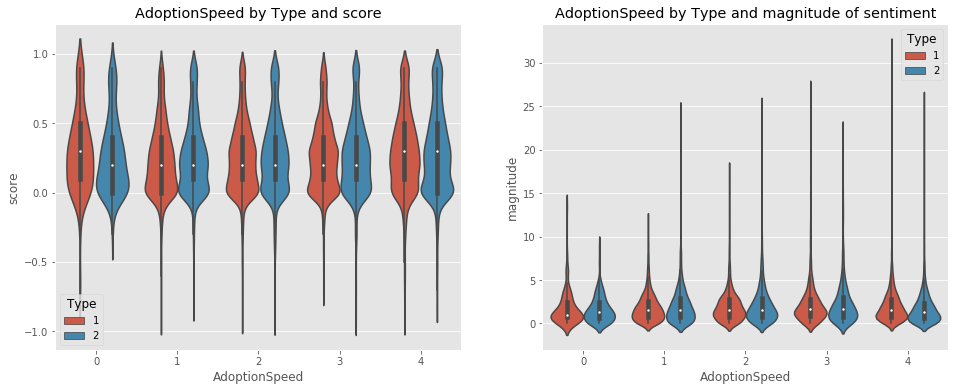

In [80]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.violinplot(x='AdoptionSpeed', y='score', hue='Type', data=train)
plt.title('AdoptionSpeed by Type and score')

plt.subplot(1, 2, 2)
sns.violinplot(x='AdoptionSpeed', y='magnitude', hue='Type', data=train)
plt.title('AdoptionSpeed by Type and magnitude of sentiment')

In [81]:
cols_to_use = ['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 
               'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 
               'Quantity', 'Fee', 'State', 'RescuerID', 'health', 'Free', 'score', 'VideoAmt', 
               'PhotoAmt', 'AdoptionSpeed', 'No_name', 'Pure_breed', 'desc_length', 'desc_words', 
               'average_word_length', 'magnitude']
train = train[[col for col in cols_to_use if col in train.columns]]
test = test[[col for col in cols_to_use if col in test.columns]]

In [82]:
cat_cols = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 
            'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'State', 'RescuerID', 
            'No_name', 'Pure_breed', 'health', 'Free']

In [83]:
more_cols = []
for col1 in cat_cols:
    for col2 in cat_cols:
        if col1 != col2 and col1 not in ['RescuerID', 'State'] and col2 not in ['RescuerID', 'State']:
            train[col1 + '_' + col2] = train[col1].astype(str) + '_' + train[col2].astype(str)
            test[col1 + '_' + col2] = test[col1].astype(str) + '_' + test[col2].astype(str)
            more_cols.append(col1 + '_' + col2)
cat_cols = cat_cols + more_cols

In [84]:
%%time
indexer = {}
for col in cat_cols:
#     print(col)
    _, indexer[col] = pd.factorize(train[col].astype(str))
    
for col in tqdm_notebook(cat_cols):
#     print(col)
    train[col] = indexer[col].get_indexer(train[col].astype(str))
    test[col] = indexer[col].get_indexer(test[col].astype(str))


Wall time: 6.82 s


In [85]:
y = train['AdoptionSpeed']
train = train.drop(['AdoptionSpeed'], axis=1)

## Naive multiclass LGB

In [86]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=15)

In [95]:
def train_model(X=train, X_test=test, y=y, params=None, folds=folds, model_type='lgb', 
                plot_feature_importance=False, averaging='usual', make_oof=False):
    result_dict = {}
    if make_oof:
        oof = np.zeros((len(X), 5))
    prediction = np.zeros((len(X_test), 5))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        gc.collect()
        print('Fold', fold_n + 1, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
            valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_cols)
            
            model = lgb.train(params, 
                              train_data,
                              num_boost_round=20000, 
                              valid_sets=[train_data, valid_data], 
                              verbose_eval=500,
                              early_stopping_rounds=200)
            del train_data, valid_data
            
            y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
            del X_valid
            gc.collect()
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)
            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, 
                              early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
            
        if model_type == 'lcv':
            model = LogisticRegressionCV(scoring='neg_log_loss', cv=3, multi_class='multinomial')
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, loss_function='MultiClass', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), 
                      cat_features=[], use_best_model=True, verbose=False)
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test).reshape(-1,)
        
        if make_oof:
            oof[valid_index] = y_pred_valid
        
        scores.append(kappa(y_valid, y_pred_valid.argmax(1)))
        print('Fold kappa:', kappa(y_valid, y_pred_valid.argmax(1)))
        print('')
        
        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance['feature'] = X.columns
            fold_importance['importance'] = model.feature_importance()
            fold_importance['fold'] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
        
    prediction /= n_fold
    print('CV mean score: {}, std: {}.'.format(round(np.mean(scores), 4), round(np.std(scores), 4)))
        
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance['importance'] /= n_fold
            cols = feature_importance[['feature', 'importance']].groupby('feature').mean().sort_values(
                by='importance', ascending=False)[:50].index
            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
            plt.figure(figsize=(16, 12))
            sns.barplot(x='importance', y='feature', 
                        data=best_features.sort_values(by='importance', ascending=False))
            plt.title('LGB Features (avg over folds)')
            result_dict['feature_importance'] = feature_importance
        
    result_dict['prediction'] = prediction
    if make_oof:
        result_dict['oof'] = oof
        
    return result_dict

In [96]:
params = {'num_leaves': 512, 
          'objective': 'multiclass', 
          'max_depth': -1, 
          'learning_rate': 0.01, 
          'boosting': 'gbdt', 
          'feature_fraction': 0.9, 
          'bagging_freq': 3, 
          'bagging_fraction': 0.9, 
          'bagging_seed': 11,
          'random_state': 42, 
          'verbosity': -1, 
          'num_class': 5}

Fold 1 started at Wed Apr  3 15:00:03 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's multi_logloss: 0.362904	valid_1's multi_logloss: 1.31312
Early stopping, best iteration is:
[315]	training's multi_logloss: 0.580484	valid_1's multi_logloss: 1.2997
Fold kappa: 0.3580619482695119

Fold 2 started at Wed Apr  3 15:01:12 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's multi_logloss: 0.363237	valid_1's multi_logloss: 1.30512
Early stopping, best iteration is:
[367]	training's multi_logloss: 0.508585	valid_1's multi_logloss: 1.29716
Fold kappa: 0.3490393540188583

Fold 3 started at Wed Apr  3 15:02:29 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's multi_logloss: 0.365122	valid_1's multi_logloss: 1.30156
Early stopping, best iteration is:
[348]	training's multi_logloss: 0.536105	valid_1's multi_logloss: 1.29317
Fold kappa: 0.35769092555957815

Fold 4 started at Wed Apr  3 15:03:44

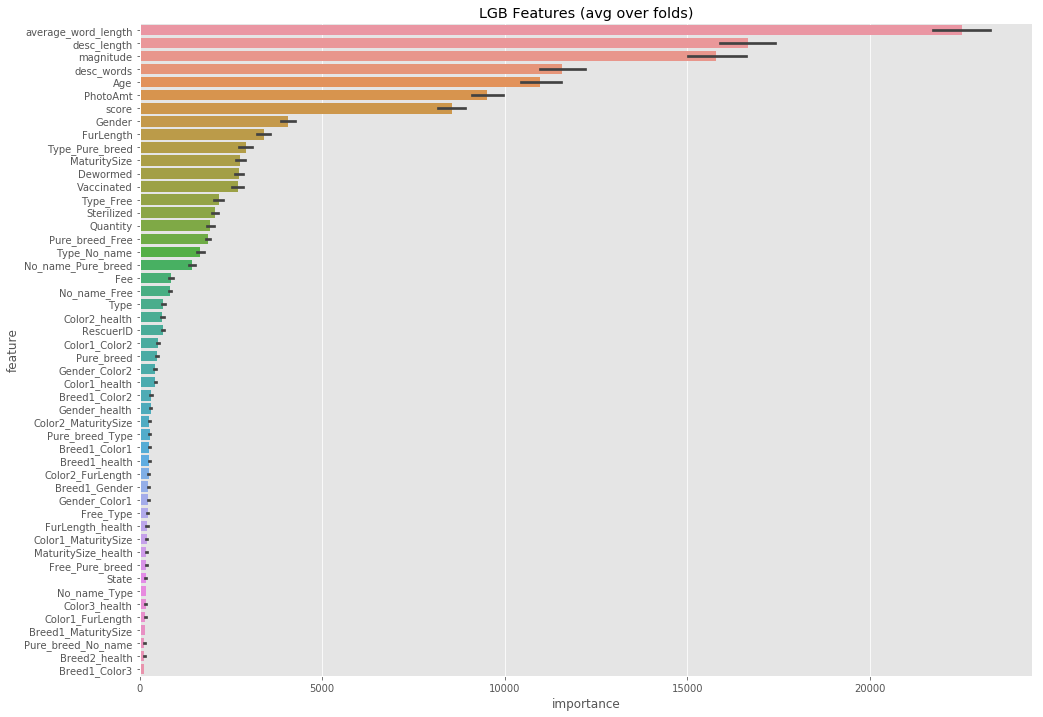

In [97]:
result_dict_lgb = train_model(X=train, X_test=test, y=y, params=params, model_type='lgb', 
                              plot_feature_importance=True, make_oof=True)

In [98]:
xgb_params = {'eta': 0.01, 'max_depth': 9, 'subsample': 0.9, 'colsamplebytree': 0.9, 
              'objective': 'multi:softprob', 'eval_metric': 'merror', 'silent': True, 
              'nthread': 4, 'num_class': 5}
result_dict_xgb = train_model(params=xgb_params, model_type='xgb', make_oof=True)

Fold 1 started at Wed Apr  3 15:09:12 2019
[0]	train-merror:0.438339	valid_data-merror:0.631333
Multiple eval metrics have been passed: 'valid_data-merror' will be used for early stopping.

Will train until valid_data-merror hasn't improved in 200 rounds.
[500]	train-merror:0.110314	valid_data-merror:0.551333
Stopping. Best iteration:
[551]	train-merror:0.098474	valid_data-merror:0.549

Fold kappa: 0.3732948510918874

Fold 2 started at Wed Apr  3 15:14:31 2019
[0]	train-merror:0.428083	valid_data-merror:0.627
Multiple eval metrics have been passed: 'valid_data-merror' will be used for early stopping.

Will train until valid_data-merror hasn't improved in 200 rounds.
[500]	train-merror:0.10923	valid_data-merror:0.564
[1000]	train-merror:0.042692	valid_data-merror:0.556667
Stopping. Best iteration:
[925]	train-merror:0.050613	valid_data-merror:0.554333

Fold kappa: 0.34586074882101636

Fold 3 started at Wed Apr  3 15:22:17 2019
[0]	train-merror:0.421342	valid_data-merror:0.621414
Multipl

In [110]:
prediction = (result_dict_lgb['prediction'] + result_dict_xgb['prediction']).argmax(1)
submission = pd.DataFrame({'PetID': sub.PetID, 'AdoptionSpeed': [int(i) for i in prediction]})
submission.head()

PetID  AdoptionSpeed
0  378fcc4fc              2
1  73c10e136              4
2  72000c4c5              4
3  e147a4b9f              3
4  43fbba852              4